# Bushfire Analysis using Meteorological Data

Programming Language: R 3.5.1 in Jupyter Notebook

R Libraries used:
- psych
- ggplot2
- ggpubr
- dplyr
- reshape2
- lightgbm
- rpart
- caret
- methods
- leaps
- glmnet
- ipred
- plyr
- data.table
- Matrix

## Table of Contents

* [Introduction](#sec_1)
* [Data Exploration](#sec_2)
* [Model Development](#sec_3)
* [Model Comparison](#sec_4)
* [Variable Identification and Explanation](#sec_5)
* [Conclusion](#sec_6)
* [References](#sec_7)

## 1. Introduction <a class="anchor" id="sec_1"></a>

### Dataset description  

   1. **X** - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. **Y** - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. **month** - month of the year: "jan" to "dec" 
   4. **day** - day of the week: "mon" to "sun"
   5. **FFMC** - FFMC index from the FWI system. It is a rating of fine fuels. It shows relative ease of ignition of fuels. 18.7 to 96.20
   6. **DMC** - DMC index from the FWI system. It is a numerical rating of the average moisture content of organic layers at moderate depth :  1.1 to 291.3 [Read more](https://www.malagaweather.com/fwi-txt.htm)
   7. **DC** - DC index from the FWI system. It is a numerical rating of the moisture content of deep, compact organic layers. 7.9 to 860.6 
   8. **ISI** - ISI index from the FWI system. Rate at which fire will spread in early stages: 0.0 to 56.10
   9. **temp** - temperature in Celsius degrees: 2.2 to 33.30
   10. **RH** - relative humidity in %: 15.0 to 100
   11. **wind** - wind speed in km/h: 0.40 to 9.40 
   12. **rain** - outside rain in mm/m2 : 0.0 to 6.4 
   13. **area** - the burned area of the forest (in ha): 0.00 to 1090.84 
   
   No missing values present

### Read and clean data 

In [1]:
fire_df <- read.csv('forestfires.csv', header = TRUE)

In [2]:
dim(fire_df)

[1] 517  13

In [3]:
head(fire_df)

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


## 2. Data Exploration<a class="anchor" id="sec_2"></a>

### Descriptive Statistics

In [4]:
summary(fire_df)

       X               Y           month      day          FFMC      
 Min.   :1.000   Min.   :2.0   aug    :184   fri:85   Min.   :18.70  
 1st Qu.:3.000   1st Qu.:4.0   sep    :172   mon:74   1st Qu.:90.20  
 Median :4.000   Median :4.0   mar    : 54   sat:84   Median :91.60  
 Mean   :4.669   Mean   :4.3   jul    : 32   sun:95   Mean   :90.64  
 3rd Qu.:7.000   3rd Qu.:5.0   feb    : 20   thu:61   3rd Qu.:92.90  
 Max.   :9.000   Max.   :9.0   jun    : 17   tue:64   Max.   :96.20  
                               (Other): 38   wed:54                  
      DMC              DC             ISI              temp      
 Min.   :  1.1   Min.   :  7.9   Min.   : 0.000   Min.   : 2.20  
 1st Qu.: 68.6   1st Qu.:437.7   1st Qu.: 6.500   1st Qu.:15.50  
 Median :108.3   Median :664.2   Median : 8.400   Median :19.30  
 Mean   :110.9   Mean   :547.9   Mean   : 9.022   Mean   :18.89  
 3rd Qu.:142.4   3rd Qu.:713.9   3rd Qu.:10.800   3rd Qu.:22.80  
 Max.   :291.3   Max.   :860.6   Max.   :56.

Maximum area of fire at a particular X, Y point is **1090.84.**

In [5]:
str(fire_df)

'data.frame':	517 obs. of  13 variables:
 $ X    : int  7 7 7 8 8 8 8 8 8 7 ...
 $ Y    : int  5 4 4 6 6 6 6 6 6 5 ...
 $ month: Factor w/ 12 levels "apr","aug","dec",..: 8 11 11 8 8 2 2 2 12 12 ...
 $ day  : Factor w/ 7 levels "fri","mon","sat",..: 1 6 3 1 4 4 2 2 6 3 ...
 $ FFMC : num  86.2 90.6 90.6 91.7 89.3 92.3 92.3 91.5 91 92.5 ...
 $ DMC  : num  26.2 35.4 43.7 33.3 51.3 ...
 $ DC   : num  94.3 669.1 686.9 77.5 102.2 ...
 $ ISI  : num  5.1 6.7 6.7 9 9.6 14.7 8.5 10.7 7 7.1 ...
 $ temp : num  8.2 18 14.6 8.3 11.4 22.2 24.1 8 13.1 22.8 ...
 $ RH   : int  51 33 33 97 99 29 27 86 63 40 ...
 $ wind : num  6.7 0.9 1.3 4 1.8 5.4 3.1 2.2 5.4 4 ...
 $ rain : num  0 0 0 0.2 0 0 0 0 0 0 ...
 $ area : num  0 0 0 0 0 0 0 0 0 0 ...


In [6]:
library(psych)
describe(fire_df)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X,1,517,4.66924565,2.3137778,4.00,4.672289,2.965200,1.0,9.00,8.00,0.03603577,-1.1796691,0.10175983
Y,2,517,4.29980658,1.2299004,4.00,4.308434,1.482600,2.0,9.00,7.00,0.41487792,1.3782826,0.05409096
month*,3,517,6.75822050,4.3732754,7.00,6.720482,7.413000,1.0,12.00,11.00,0.08358697,-1.7193189,0.19233643
day*,4,517,3.73694391,1.9250613,4.00,3.672289,2.965200,1.0,7.00,6.00,0.15684203,-1.1093028,0.08466410
FFMC,5,517,90.64468085,5.5201108,91.60,91.454940,1.927380,18.7,96.20,77.50,-6.53749886,66.1393621,0.24277420
DMC,6,517,110.87234043,64.0464822,108.30,106.522410,51.742740,1.1,291.30,290.20,0.54432492,0.1789299,2.81676107
DC,7,517,547.94003868,248.0661917,664.20,578.692289,118.904520,7.9,860.60,852.70,-1.09406780,-0.2650719,10.90993864
ISI,8,517,9.02166344,4.5594772,8.40,8.727470,3.113460,0.0,56.10,56.10,2.52162669,21.1458110,0.20052558
temp,9,517,18.88916828,5.8066253,19.30,19.091084,5.337360,2.2,33.30,31.10,-0.32925302,0.1111986,0.25537509
RH,10,517,44.28820116,16.3174692,42.00,42.706024,14.826000,15.0,100.00,85.00,0.85790328,0.4091470,0.71764148


Some overservations can be made from the above numbers:

1. Skewness for FFMC, rain and area is relatively higher. 
2. Kurtosis is higher for these columns as well. 

These type of columns can have higher implication on performance of the model we build, so we need to deal with it. This is beacuse the tail region may act as a outliers which may adversely affect linear modelling.

Rest of the value seems normal and will be explored at a later stage.

So lets plot distribution graph for each of these variables to gain more insights


In [7]:
library(ggplot2)
library(ggpubr) 

Warning message:
"package 'ggplot2' was built under R version 3.5.3"
Attaching package: 'ggplot2'

The following objects are masked from 'package:psych':

    %+%, alpha

Loading required package: magrittr
Warning message:
"package 'magrittr' was built under R version 3.5.3"

In [8]:
p <- ggplot(fire_df, aes(x=FFMC)) +
    geom_histogram(aes(y=..density..), color="black", fill="lightblue", alpha = 0.4) +
    geom_density(color="darkblue", size=0.8) +
    geom_vline(aes(xintercept=mean(FFMC)),
            color="black", linetype="dashed", size=1)

q <- ggplot(fire_df, aes(x=ISI)) +
    geom_histogram(aes(y=..density..), color="black", fill="indianred1", alpha = 0.4) +
    geom_density(color="red", size=0.8) +
    geom_vline(aes(xintercept=mean(ISI)),
            color="black", linetype="dashed", size=1)

r <- ggplot(fire_df, aes(x=rain)) +
    geom_histogram(aes(y=..density..), color="black", fill="yellow", alpha = 0.4) +
    geom_density(color="gold2", size=0.8) 

s <- ggplot(fire_df, aes(x=area)) +
    geom_histogram(aes(y=..density..), color="black", fill="green", alpha = 0.4) +
    geom_density(color="forestgreen", size=0.8)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


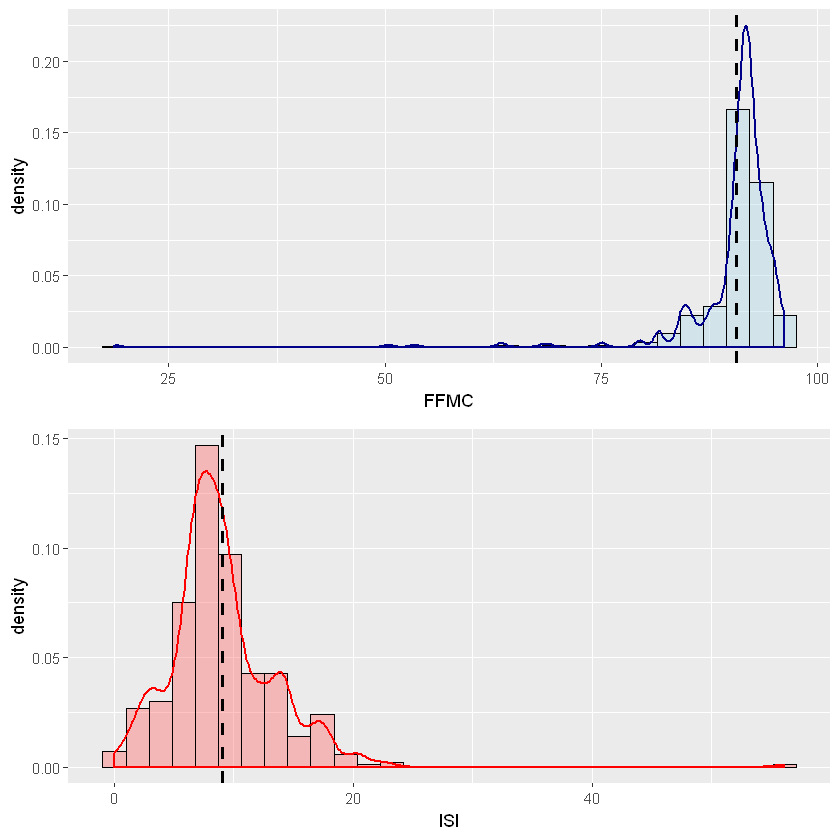

In [9]:
ggarrange(p, q,
          ncol = 1, nrow = 2,
          widths = c(1, 1), heights = c(1, 1))

From above graphs, we can confirm that:

FFMC is skewed towards left side, and
ISI is slightly / marginally positively skewed. Some transformation might be needed to make this distribution towards normal

So, None of these variables exhibits normal distribution.

Lets dive into transforming FFMC close to Gaussian Distribution.

We can see that from the graph and confirm it from output of describe() method. As the it is skewed negatively, it makes sense to use power transformation to bring/push it towards left side.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


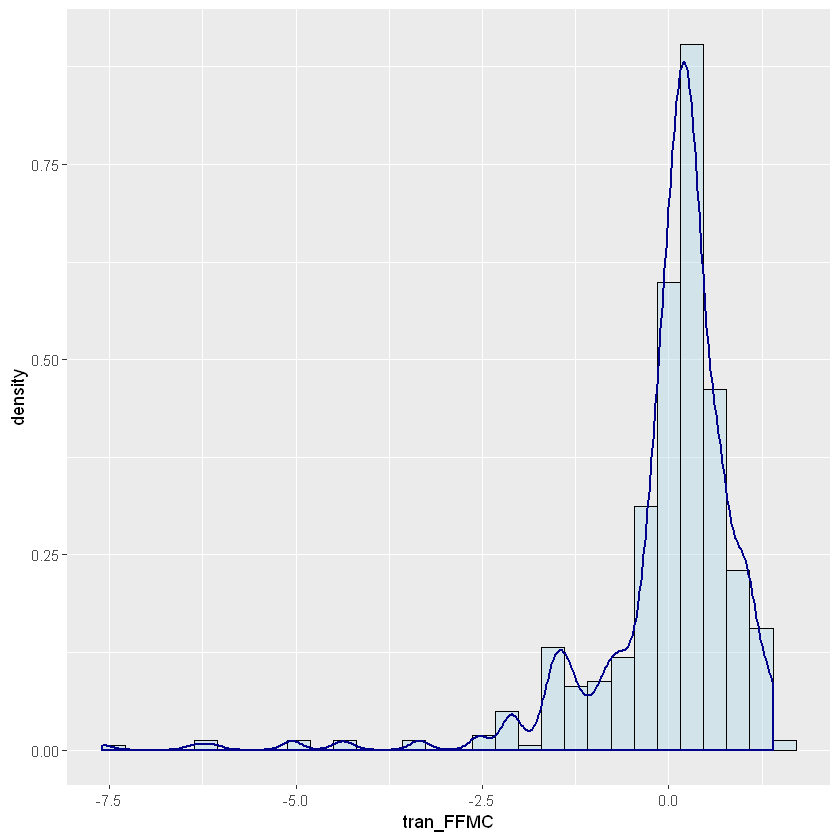

In [10]:
fire_df$tran_FFMC <- ((fire_df$FFMC)^3-mean((fire_df$FFMC)^3))/sd((fire_df$FFMC)^3)

ggplot(fire_df, aes(x=tran_FFMC)) +
    geom_histogram(aes(y=..density..), color="black", fill="lightblue", alpha = 0.4) +
    geom_density(color="darkblue", size=0.8)

So, after transformation and reshaping, it looks close to gaussian distribution, it still appears to have some outliers, but we will deal with it later.

Lets look at other two variables with higher skewness and kurtosis.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


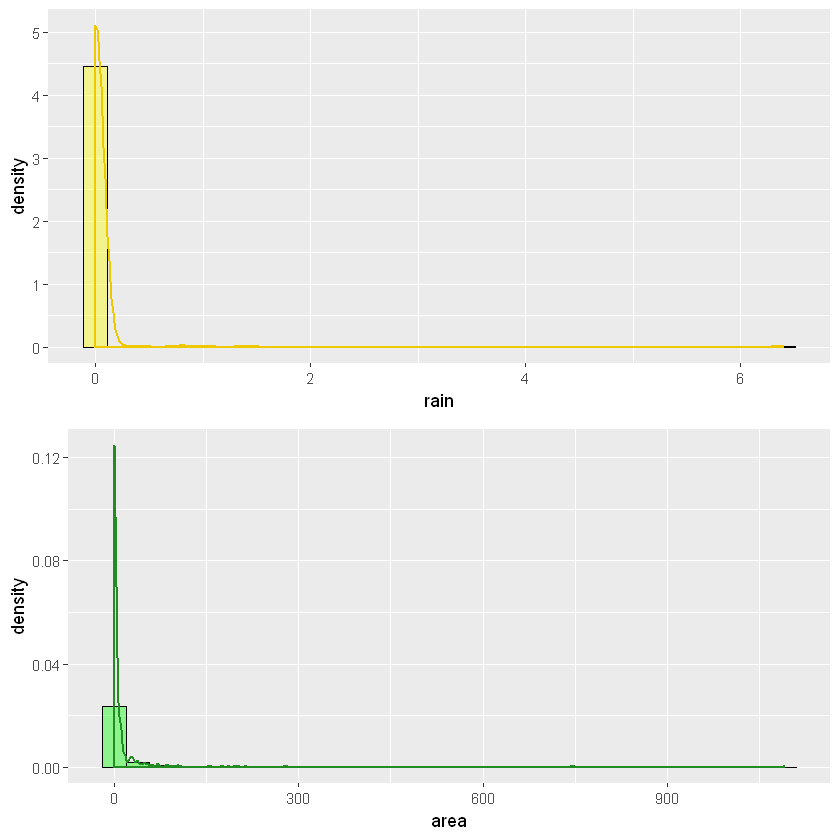

In [11]:
ggarrange(r, s,
          ncol = 1, nrow = 2,
          widths = c(1, 1), heights = c(1, 1))

From the above two graphs, we can see that area and rain are strongly skewed. This is due to high occurence of value 0 in both the columns.

Lets calculate the occurence of zeros in both these variables

In [12]:
a <- table(fire_df$area)
a[names(a)==0]

0 
247

In [13]:
(a[names(a)==0]/nrow(fire_df))*100

0 
47.77563

In [14]:
b <- table(fire_df$rain)
b[names(b)==0]

0 
509

In [15]:
(b[names(b)==0]/nrow(fire_df))*100

0 
98.45261

We can see from the above values that ~48% of values in area column are 0.

Also, around 98.45% of values in rain column is equal to 0, which says that the value in this column might not be very helpful in modelling.

In [16]:
# change levels of month
fire_df$month<- factor(fire_df$month, 
                       levels = c('jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'))


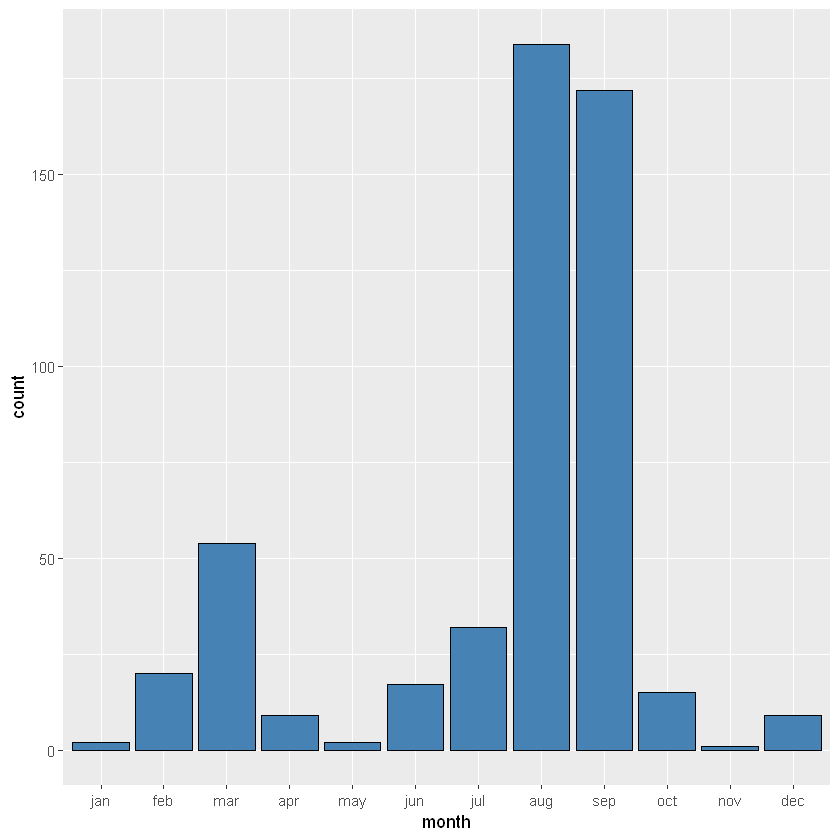

In [17]:
ggplot(fire_df, aes(x=month)) +
    geom_bar(fill='steelblue', colour='black')

From the above graph, we can see that fires were at peak in Aug-Sept months period in Portugal.

Portugal experiences summer in July to September so because of the dry wind of summer and the temperature, the chances of having fires increase.

Lets have a look at mean distribution of fire area considering X,Y as a geological point.

In [19]:
library(dplyr)

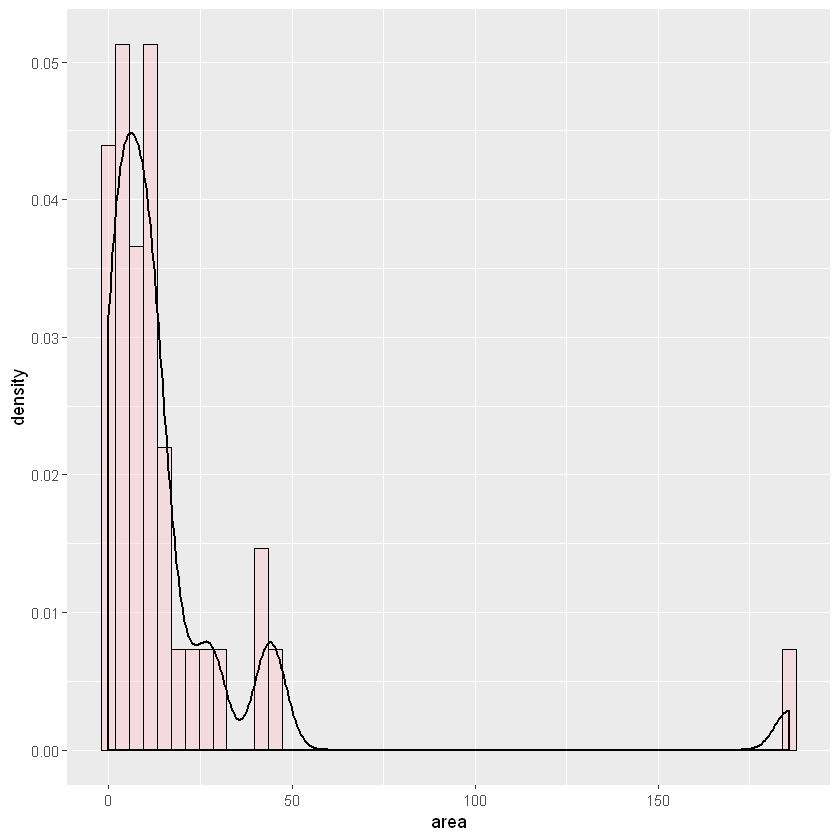

In [20]:
lookup_df <- summarize(group_by(fire_df,X, Y), area=mean(area))

lookup_df$Y <- factor(lookup_df$Y,levels = 9:1)

ggplot(lookup_df, aes(x=area)) +
    geom_histogram(aes(y=..density..), color="black", fill="pink", alpha = 0.4, bins=50) +
    geom_density(color="black", size=0.8)

It looks like in most of the region defined by (X,Y) the average spread of fire area is less than 50.

But there are quite a few region points where spread of fire area is very high. We can see this from the tail

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


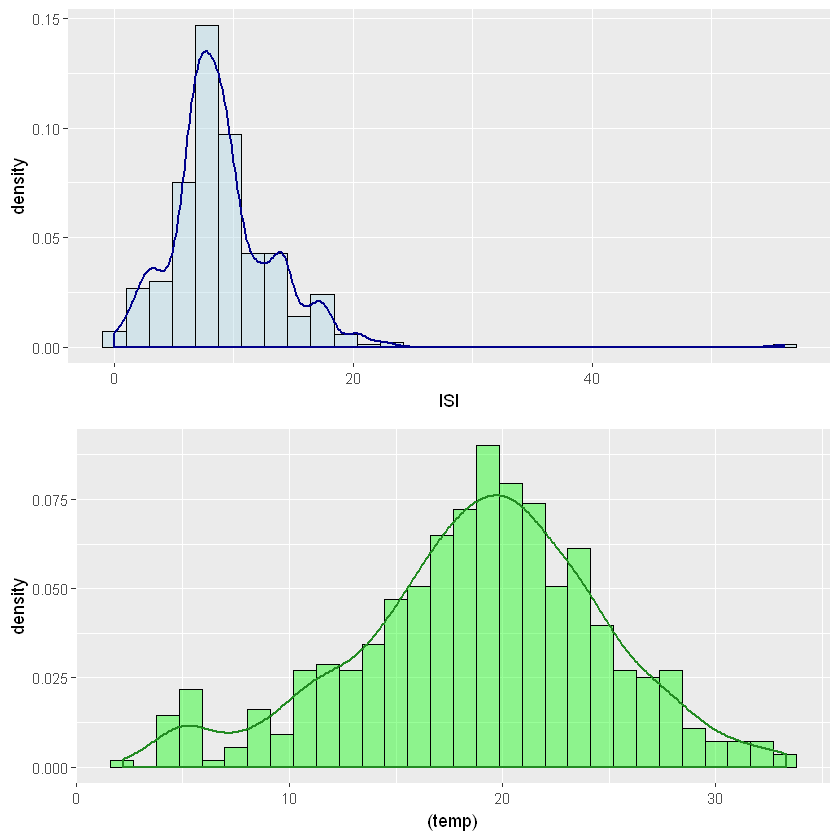

In [21]:
p1 <- ggplot(fire_df, aes(x=ISI)) +
       geom_histogram(aes(y=..density..), color="black", fill="lightblue", alpha = 0.4) +
       geom_density(color="darkblue", size=0.8)

p2 <- ggplot(fire_df, aes(x=(temp))) +
        geom_histogram(aes(y=..density..), color="black", fill="green", alpha = 0.4) +
        geom_density(color="forestgreen", size=0.8)

ggarrange(p1, p2,
          ncol = 1, nrow = 2,
          widths = c(1, 1), heights = c(1, 1))

In ISI, it appears to have an outlier. Once we remove it it will exhibit normal distribution. 

### Geographical points exploration

In [22]:
X <- as.factor(c(1:9,1:9))
Y <- as.factor(rep(c(1,7), each=9))
Freq <- rep(0, each=18)

In [23]:
coordinates_df <- rbind(data.frame(table(fire_df[,c('X','Y')])),data.frame(X,Y,Freq))
coordinates_df$Y <- factor(coordinates_df$Y, levels=9:1)

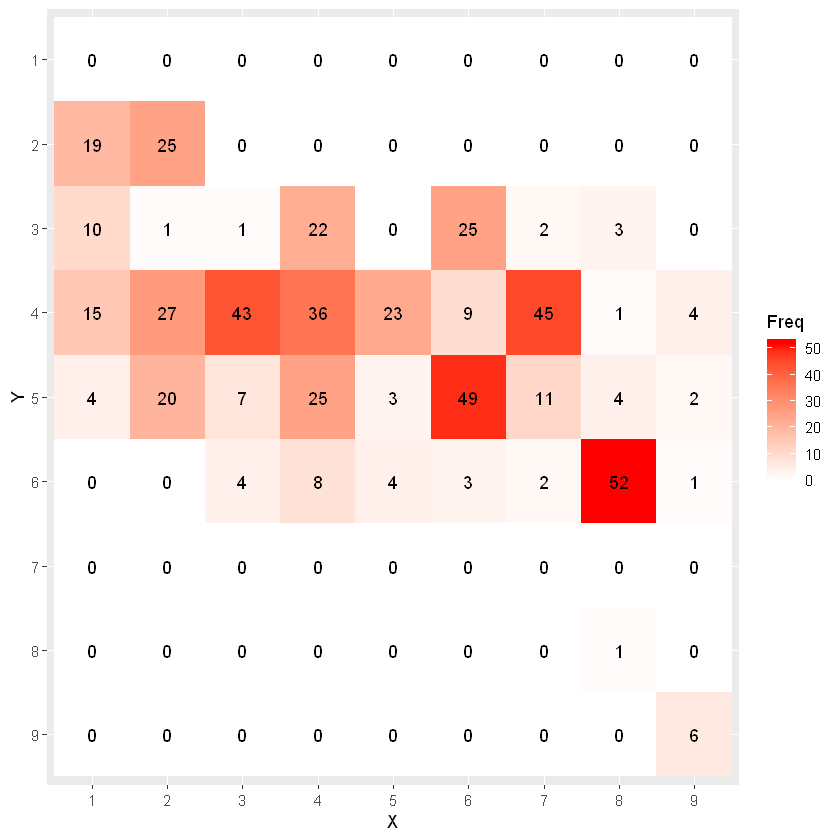

In [24]:
ggplot(coordinates_df, aes(X, Y)) +
    geom_tile(aes(fill = Freq)) + 
    geom_text(aes(label = round(Freq, 1))) +
    scale_fill_gradient(low = "white", high = "red") 

From the above values, we can see that fires were not present in higher coordinate value of Y for almost all values of X. So, as per below map of Montesinho National Park, we can see that those coordinates, does not belongs to National Park. It is possibe that as these points does not belong to Park, there would be open space or mountains ranges which has less likelihood of getting affected by fire.

If we see top coordinates for 1 and 2 values of Y coordinates, we see many zero values. This is because of the fact that, those point are excluded from Portugal region and belong to different country and so the data points were recorded for coordinates with Y value 1 ( I have explicitly added those values as 0 to make the heat map look similar to coordinates of below map).

![The map](https://www.researchgate.net/profile/Youssef_Safi2/publication/290160237/figure/fig4/AS:325226018689027@1454551333381/The-map-of-Montesinho-natural-park.png "The map of Montesinho National Park")

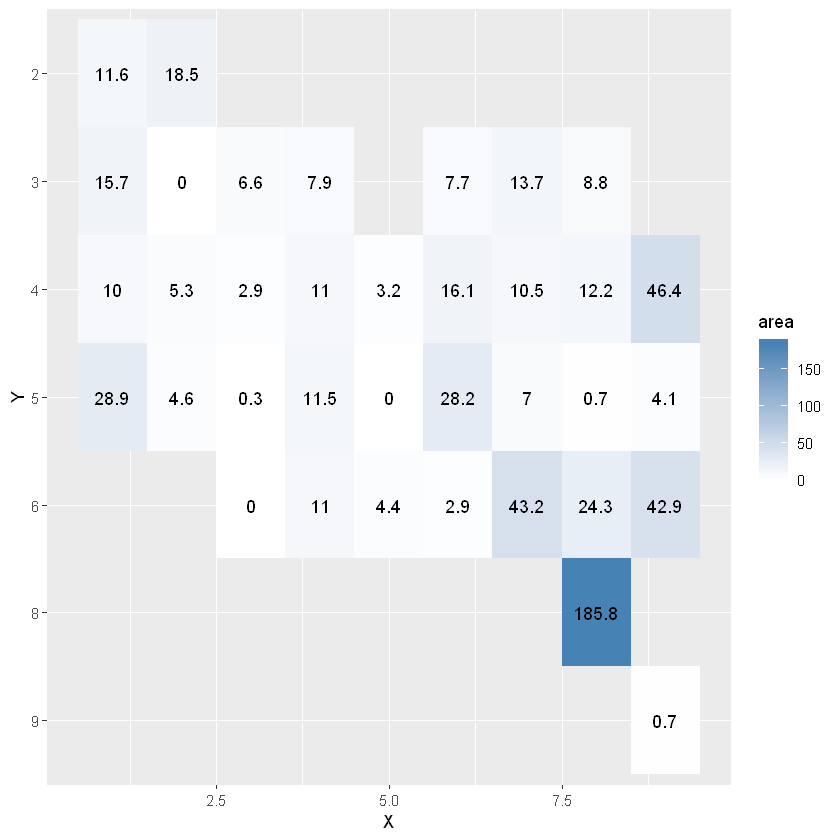

In [25]:
lookup_df <- summarise(group_by(fire_df,X, Y), area=mean(area))

lookup_df$Y <- factor(lookup_df$Y,levels = 9:1)

ggplot(lookup_df, aes(X, Y, fill= area)) + 
  geom_tile(aes(fill = area))+
    geom_text(aes(label = round(area, 1))) +
  scale_fill_gradient(low="white", high="steelblue")

As we already know, lots of values are zero for area. So, even if we take those rows into consideration, mean values for each point at X,Y shows that at (8,8) there were large fires.

### Correlation

Lets have a look at correlation among variables.

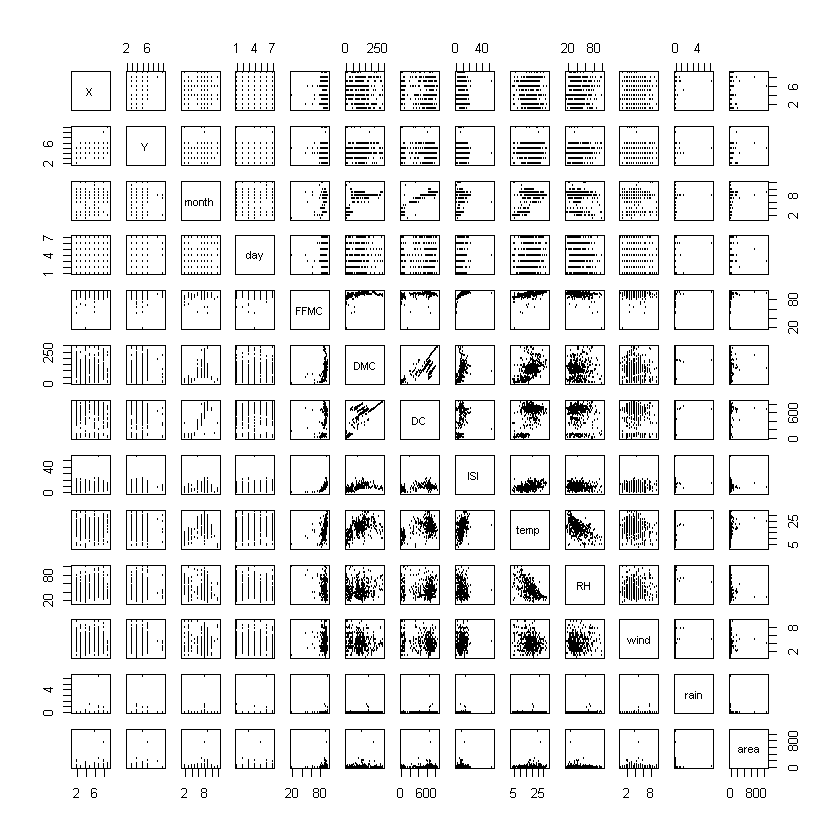

In [26]:
pairs(fire_df[1:13],cex=0.2)

It seems difficult to determine correlation among many variables.

- However, from the above graph we can see that **Temperature** and **RH (Relative Humidity)** are negatively correlated. This is because of the fact that as temperature increases, air gets warmer which can hold more water molecules, so its relative humidity decreases. When temperatures drop, relative humidity increases. [Read more](https://sciencing.com/temperature-ampamp-humidity-related-7245642.html)

- Also, **DMC** and **DC** shows strong positive correlation. As DMC and DC are moisture code for organic layers at moderate depth and very great depth, it makes sense to believe that moisture at moderate depth increase with increase in moisture content at deep layers. [Read more](https://www.malagaweather.com/fwi-txt.htm)

- **ISI** and **Temp** shows descent positive relationship/correlation. We can see this relationship because it rate at which fire will spread (ISI) increases with temperature surging up. 

In [27]:
library(reshape2)

Warning message:
"package 'reshape2' was built under R version 3.5.3"

In [28]:
names(fire_df)

[1] "X"         "Y"         "month"     "day"       "FFMC"      "DMC"      
 [7] "DC"        "ISI"       "temp"      "RH"        "wind"      "rain"     
[13] "area"      "tran_FFMC"

Using month as id variables


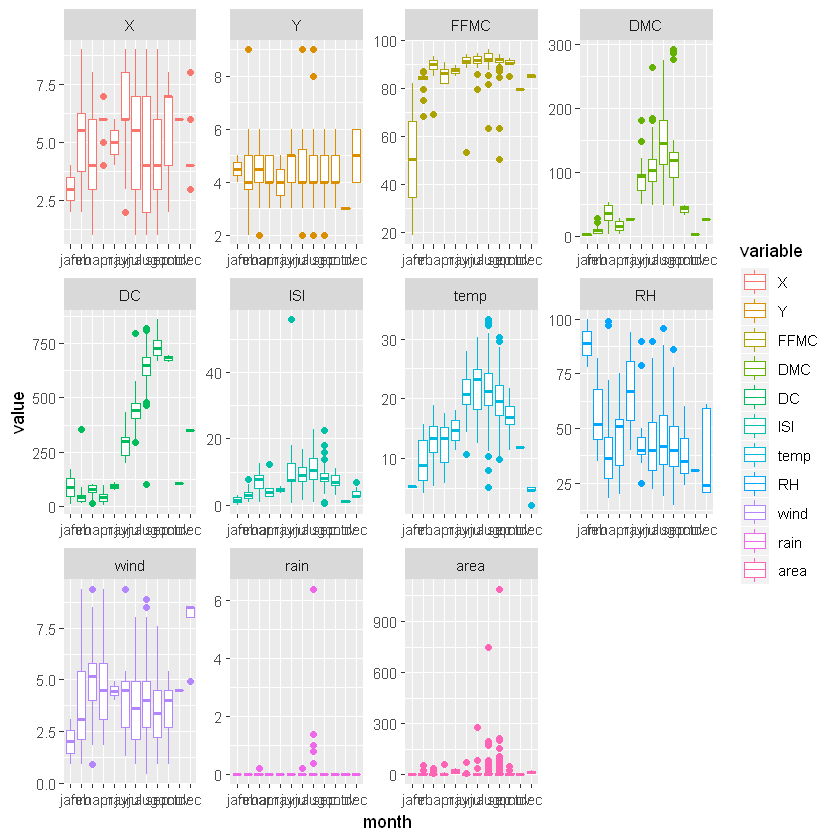

In [29]:
f1 <- melt(as.data.frame(fire_df[,c(-4, -14, -15)]))

ggplot(f1,aes(x = month,y = value, color=variable)) +
facet_wrap(~variable, scales="free") +
geom_boxplot() +
scale_y_continuous(labels=function (n) {format(n, scientific=FALSE)})

From the above plots, following insights can be derived. After grouping the values based on months, we can see that:

- **DMC** values are higher in July, August and September months. We see fire spreading more in these months, as a result this metric is higher, which expresses moisture conditions of loosely-compacted layers. Also, this metric is often used in predicting the chances of fire by lightning. [Read more](http://www.eumetrain.org/data/3/30/navmenu.php?tab=3&page=6.0.0) 

- Also, **DC** values are greater in July, August, and September. This value represents the long-term moisture conditions. So, we see higher correlation between DMC and DC variables. 

- Temperature is higher in these three months, as these are summer months in Portugal and also increase in spread of fire in these months increases the temperature to some extent.

- Most people go out in this season for hiking in summer season, so it highly likely the large fires that have occured in August and September might have caused due to some human activities.

- We see that considerable rain has fallen just in August and September. Because, due to higher temperature the moisture from the air condenses in the cloud and then falls as rain, often extinguishing the fire. [Read more](https://en.wikipedia.org/wiki/Flammagenitus_(cloud))

- In this case, after large fires were reported in August and Septmber, they might have been extinguished by the rain itself so we don't see much spread of fires after September. There have been several examples of such incidents where wildfires were distinguished by rain itself. [Read more](https://en.wikipedia.org/wiki/Flammagenitus_(cloud))

- Also, due to high rain in these months, we see more moisture in the soil layers indicated by **DMC and DC**.

- Relative Humidity reflects the amount of moisture in the atmosphere. Higher temperature leads to dry atmosphere resulting in low relative humidity. So, due to low relative humidity, dire starts to burn more vigorously. So RH values are lower in summer and fall. [Read more](https://www.auburn.edu/academic/forestry_wildlife/fire/weather_elements.htm)

- **ISI** indicates the rate at which fire will spread in its early stage. So, ISI is higher in few months ahead of September and decreases as the chances fire spread becomes lower after September as there are very few fires after September. [Read more](https://www.malagaweather.com/fwi-txt.htm)  


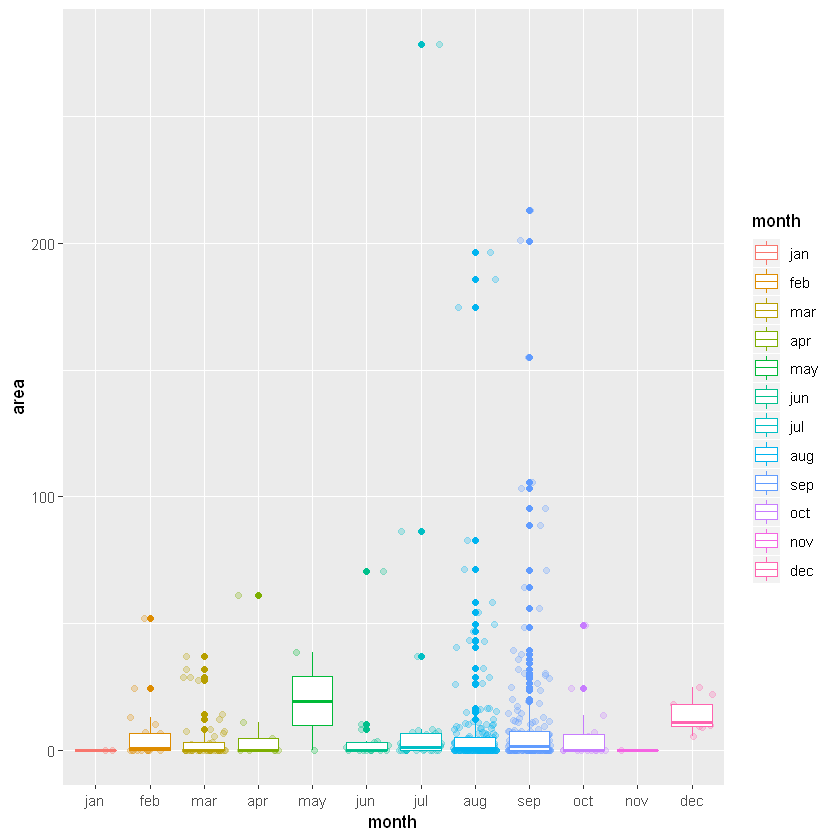

In [30]:
ggplot(fire_df[(fire_df$area<500),], aes(x=month, y=area, color=month)) +
geom_point(aes(color=month),alpha=1/4, position = 'jitter') +
  geom_boxplot()

we can see that its not only the temp that might have caused more fires in aug and sept, as the temp ranges with median 22 and 18 in these two months. This shows that there were large number of fires in these two months with some spreading in small and some spreading in large areas. 

In [31]:
fire_df <- fire_df %>%
    mutate(temp_cat = case_when(temp > 25 ~ 'High',
                                  temp > 15 ~ 'Mid',
                                  TRUE ~ 'Low'))
fire_df$temp_cat <- factor(fire_df$temp_cat, levels=c('Low', 'Mid', 'High'))

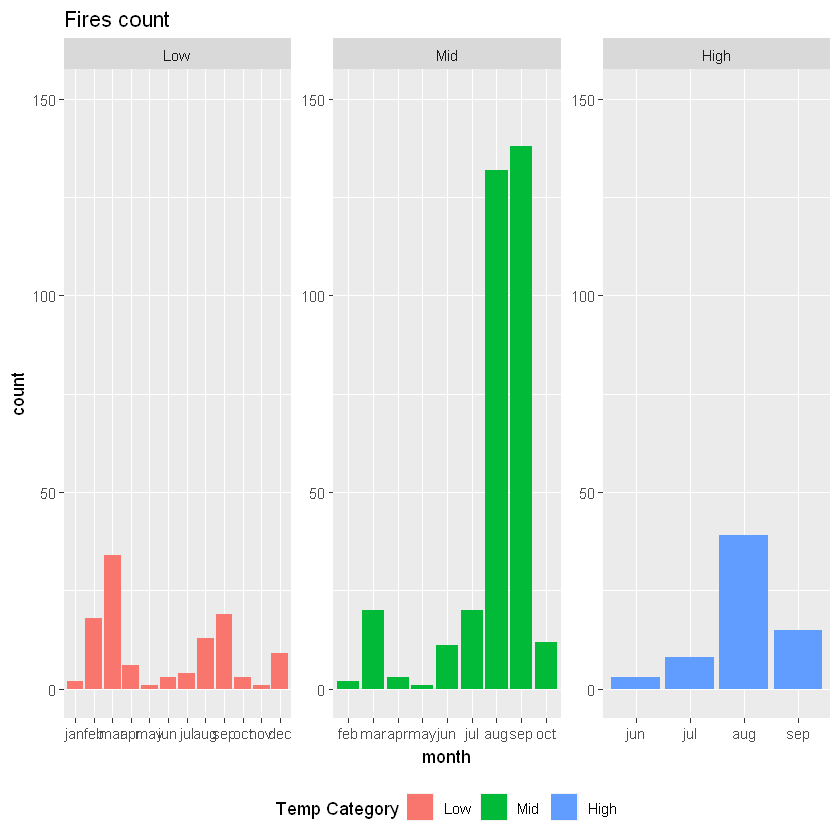

In [32]:
ggplot(aes(x=month, fill=temp_cat),data = fire_df) + 
    facet_wrap(~temp_cat, scales="free") +
    geom_bar() +
    ggtitle('Fires count') +
    theme(legend.position = "bottom", legend.box = "horizontal") +
    scale_y_continuous(limits=c(0,150)) +
    scale_fill_discrete(name="Temp Category", labels=c("Low","Mid","High"))

Here, we see that when temperature is in mid-high range, the number of entries for fires is highest in august and september. However, number of fires, for low temperatue is higher in February and March for that group.

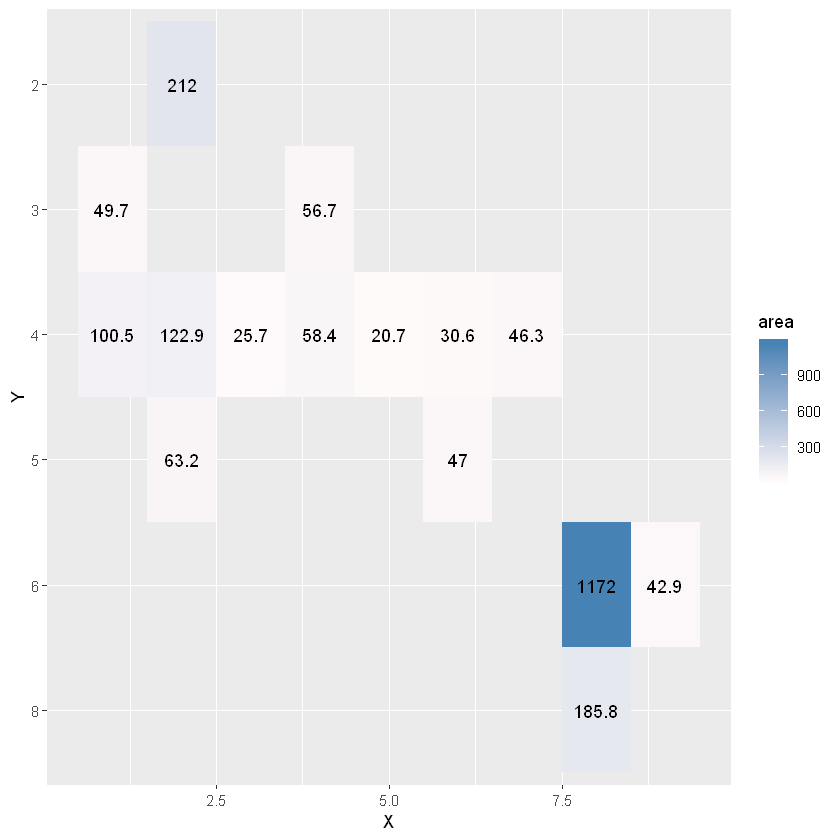

In [33]:
lookup_df <- summarise(group_by(fire_df[(fire_df$month=='aug')&(fire_df$area>0),],X, Y), area=sum(area))

lookup_df$Y <- factor(lookup_df$Y,levels = 9:1)

ggplot(lookup_df[lookup_df$area>20,], aes(X, Y, fill= area)) + 
  geom_tile(aes(fill = area))+
  geom_text(aes(label = round(area, 1))) +
  scale_fill_gradient(low="snow1", high="steelblue", guide = "colourbar",
  aesthetics = "fill")

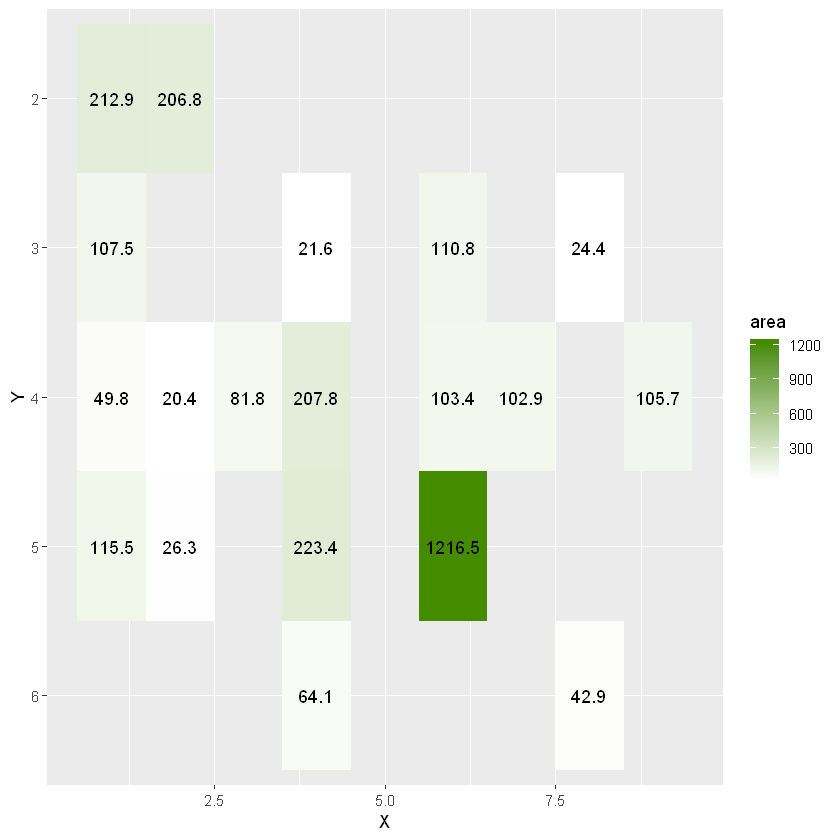

In [34]:
lookup_df <- summarise(group_by(fire_df[(fire_df$month=='sep')&(fire_df$area>0),],X, Y), area=sum(area))

lookup_df$Y <- factor(lookup_df$Y,levels = 9:1)

ggplot(lookup_df[lookup_df$area>20,], aes(X, Y, fill= area)) + 
  geom_tile(aes(fill = area))+
  geom_text(aes(label = round(area, 1))) +
  scale_fill_gradient(low="white", high="chartreuse4", guide = "colourbar",
  aesthetics = "fill")

In the above two heatmaps, we can spread of fire in August and September. We can see that there are **two to three** clusters in each month, which might be responsible for cause of fire. So there might be multiple instances in this park, where fire have been spread.

In [35]:
names(fire_df)

[1] "X"         "Y"         "month"     "day"       "FFMC"      "DMC"      
 [7] "DC"        "ISI"       "temp"      "RH"        "wind"      "rain"     
[13] "area"      "tran_FFMC" "temp_cat"

Using temp_cat as id variables


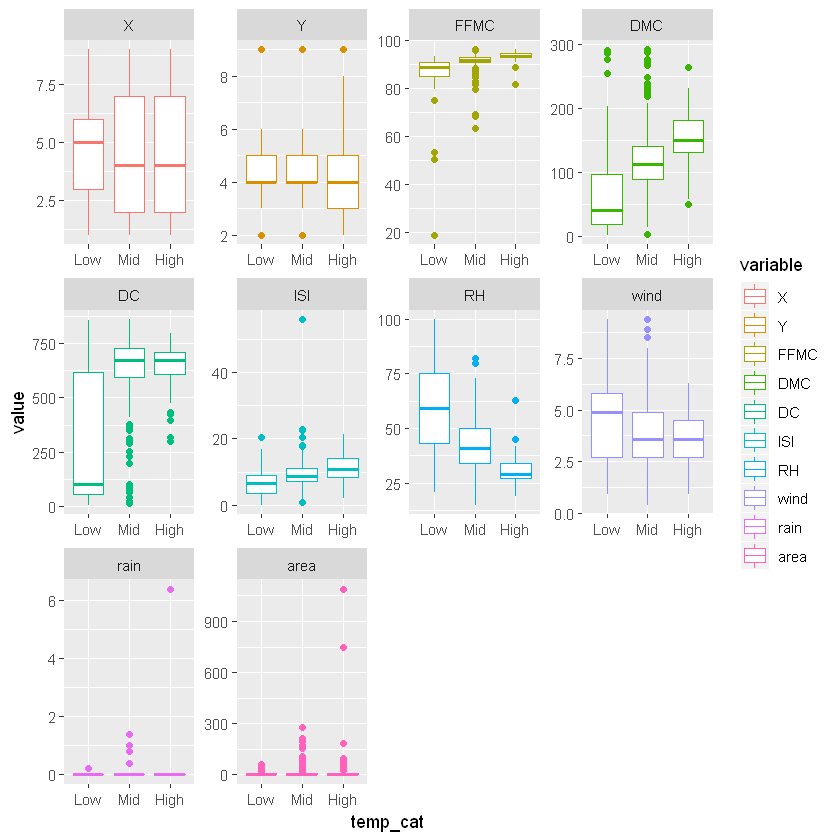

In [36]:
f1 <- melt(as.data.frame(fire_df[,c(-3, -4, -9, -14)]))

ggplot(f1,aes(x = temp_cat,y = value, color=variable)) +
facet_wrap(~variable, scales="free") +
geom_boxplot() +
scale_y_continuous(labels=function (n) {format(n, scientific=FALSE)})

We can see that Relative Humidity (RH) is higher for low temperature and it decreases with increase in the temperature. 

Also, ISI and DMC are higher for higher values of temperature category.

### Outliers detection

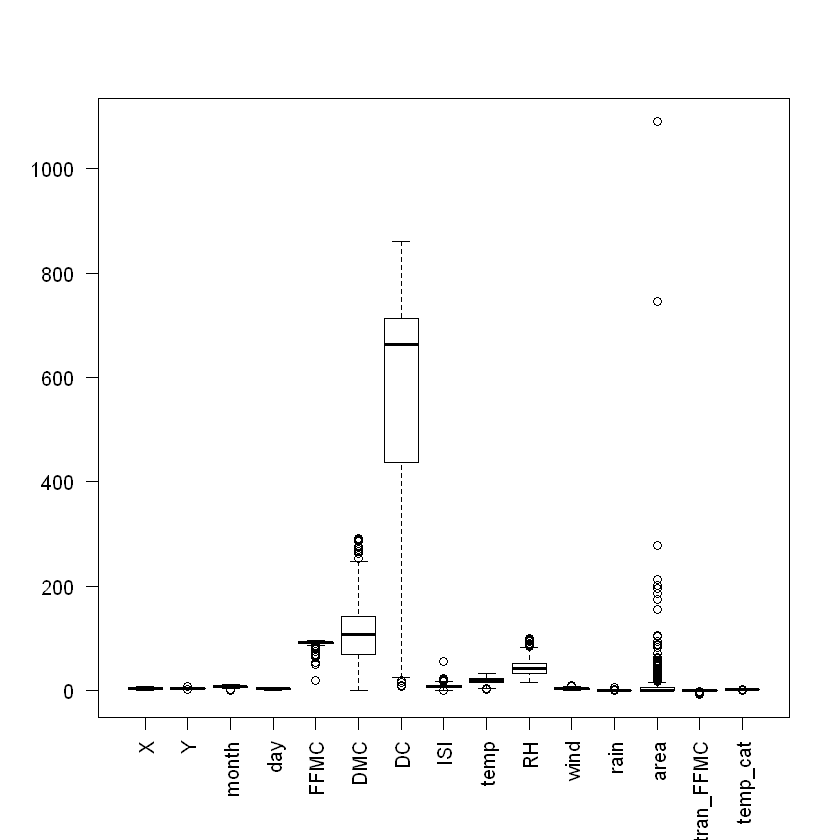

In [37]:
boxplot(fire_df, las=2, cex.axis = 1)

Most attributes are overshadowed by `DC` variable. So, it is better to create box plot for individual column 

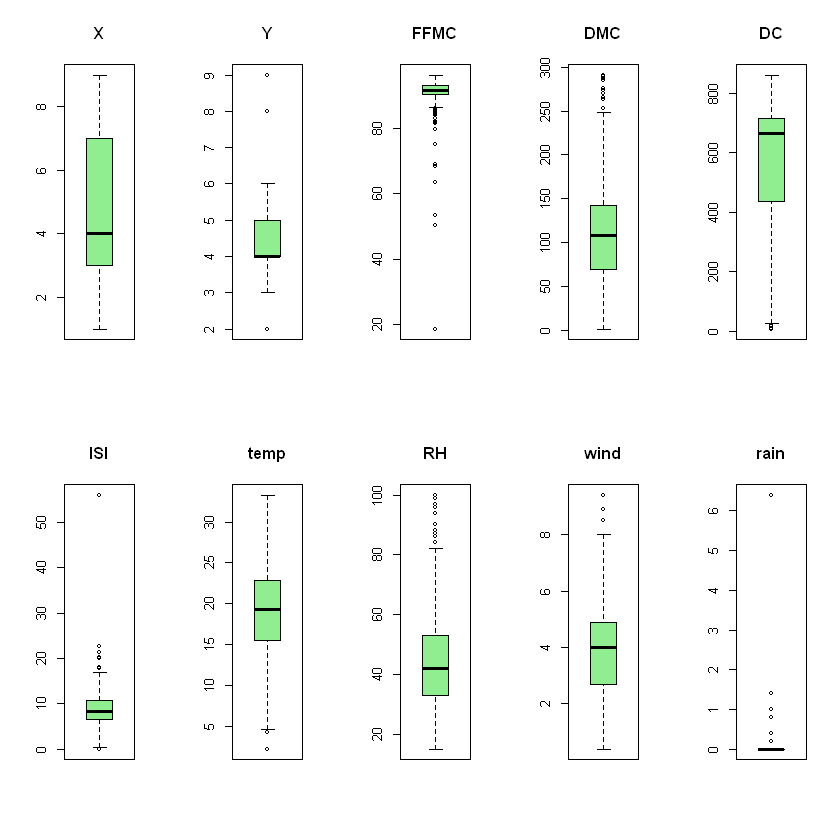

In [38]:
par(mfrow = c(2,5)) # 5 x 2 grid
for (i in 1:(length(fire_df)-3)) {
    if ((class(fire_df[,i]) == 'integer') || (class(fire_df[,i]) == 'numeric')){
        boxplot(fire_df[,i], main = names(fire_df[i]), type="l", col = 'lightgreen') 
    }
}

We can see from  the above plots that most of the columns do not show strong presence of outliers.

However, in ISI, FFMC and rain, we can see presence of outliers in the data. 

### Outliers removal

Although we can remove the outliers using constraint 1.5 * IQR, we wouldn't do that as it will incur loss of many of data points 
from our tiny dataset. And as distributions are already maintained by us, it wouldn't cause much difference if we don't strictly remove outliers.

So, we will remove extreme outliers manually.

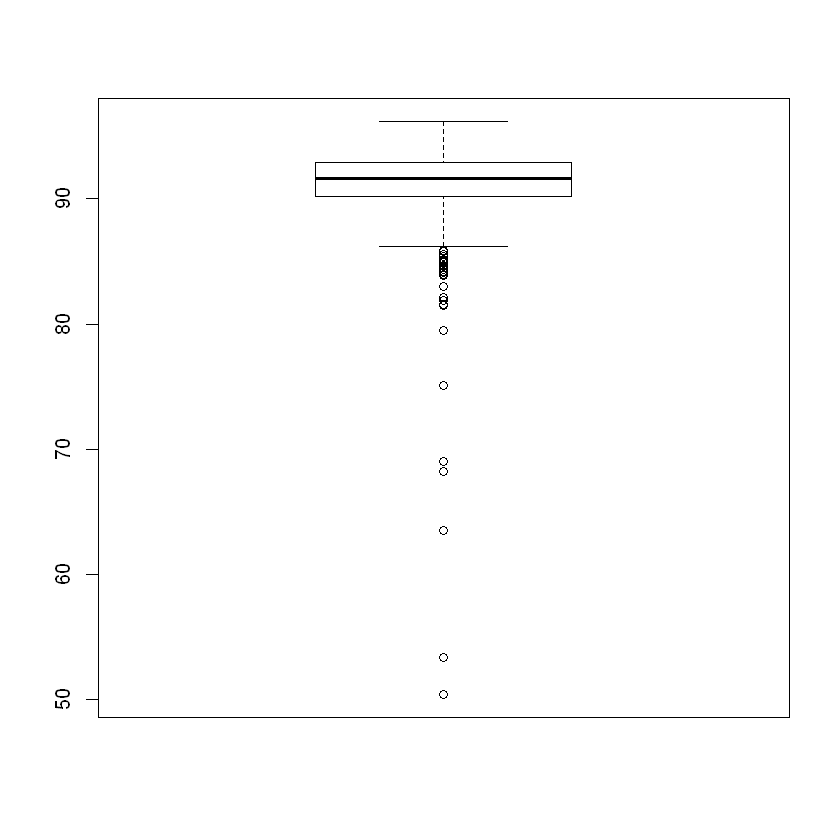

In [39]:
fire_df <- fire_df[(fire_df$ISI<50),]
fire_df <- fire_df[(fire_df$FFMC>20),]
boxplot(fire_df$FFMC)

## 3. Model Development<a class="anchor" id="sec_3"></a>

### 3.1 Multiple regression

## Need to rerun this again by substituing tran_FFMC with FFMC

Lets first create a multiple regression model with all features and see how it perform.

In [40]:
names(fire_df)

[1] "X"         "Y"         "month"     "day"       "FFMC"      "DMC"      
 [7] "DC"        "ISI"       "temp"      "RH"        "wind"      "rain"     
[13] "area"      "tran_FFMC" "temp_cat"

In [41]:
my_fit = lm(area~.-temp_cat-FFMC, data = fire_df)
summary(my_fit)


Call:
lm(formula = area ~ . - temp_cat - FFMC, data = fire_df)

Residuals:
    Min      1Q  Median      3Q     Max 
 -55.79  -17.91   -6.44    4.91 1038.78 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) -23.09427   71.26993  -0.324   0.7460  
X             2.23914    1.50101   1.492   0.1364  
Y            -0.12643    2.82696  -0.045   0.9643  
monthfeb      6.68591   66.24720   0.101   0.9197  
monthmar     -3.86321   65.75972  -0.059   0.9532  
monthapr      0.91145   68.44997   0.013   0.9894  
monthmay     13.02672   79.26950   0.164   0.8695  
monthjun      7.70755   68.93713   0.112   0.9110  
monthjul     29.96306   70.07906   0.428   0.6692  
monthaug     48.34156   72.86260   0.663   0.5073  
monthsep     75.09771   75.46377   0.995   0.3202  
monthoct     70.07338   77.16879   0.908   0.3643  
monthnov     -2.88439   92.27291  -0.031   0.9751  
monthdec     48.18208   72.17502   0.668   0.5047  
daymon        5.90043   10.52660   0.561   0.57

The adjusted R-squared ($R^2$) value indicates this model explains 0% of the variation in area.

The F-statistic **0.8693** has a p-value of **0.6576** - so it fails to reject the null hypothesis so the model does not explain anything.

The p-values for the coefficients show only DMC, DC and daysat are significant at the 0.05 level. All other variables are non significant.

Warning message:
"not plotting observations with leverage one:
  104, 515"Warning message:
"not plotting observations with leverage one:
  104, 515"

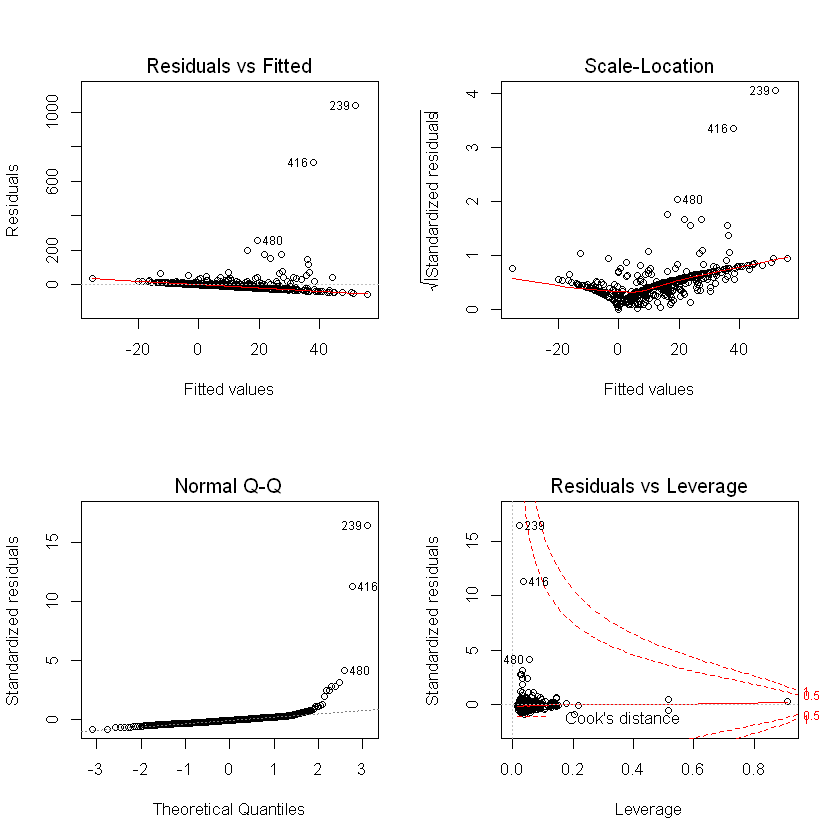

In [42]:
par(mfcol=c(2,2))
plot(my_fit)

The diagnostic plots show residuals in four different ways.

1. The **residual vs fitted plot**: This plot is used to check the linear assumption. It shows if residuals have non-linear patterns. If you find equally spread residuals around a horizontal line without distinct patterns, that is a good indication you have linear relationships. However, if the relationship between predictors and an response variable is non-linear, an obvious pattern could show up in this plot if the model cannot capture the non-linearity. The first plot aboveshows the residuals are not evenly distributed around zero. This model violates the assumption of homoscedasticity - the error terms change along the regression line and we see a clear linear line.

* The normal **Q-Q plot**: The Q-Q plot (i.e., quantile-quantile plot) is a graphical tool to help us assess if a set of data plausibly came from some theoretical distribution such as a Normal. For example, if we run a statistical analysis that assumes our dependent variable is Normally distributed, we can use a Normal Q-Q plot to check that assumption. In the case of linear regression analysis, we assume that residual is normally distributed with constant variance and mean equal to zero. The normal Q-Q plot shows if residuals are normally distributed. It is good if residuals are lined well on the straight dashed line. And of course it cannot be a perfect straight line and this will be your call. Here, the residuals does not seem to deviate significantly from the dashed line.

* The **scale-location plot**: It is used to check the assumption of equal variance by showing if residuals are spread equally along the ranges of predictors. It is good if we can see a horizontal line with equally (randomly) spread points. The scale-location plot shows the model violates the assumption of equal variance and forms a V shaped pattern

* The **residual-leverage plot**: it helps us identify influential data samples. Not all outliers are influential in linear regression analysis. Here we care about the samples that are influential to determine the regression line. These samples can very influential even if they look to be within a reasonable range of the values. They can alter the results if we exclude them from analysis. In the residual-leverage plot, we look for outlying values at the upper right corner or at the lower right corner. Samples located in those places can be influential against a regression line. We usually use Cook’s distance, indicated by a red dash line. When samples are outside of the Cook’s distance (i.e, they have high Cook’s distance scores, Cook’s distance measures how much the entire regression function changes when the i-th case is deleted.), the samples are influential to the regression results. The regression results will be altered if we exclude those samples.  The fourth plot shows there are some possibility influential outliers. Points 239, and 416 seems to be very close to boundry line. Lets look at corresponding rows.

In [43]:
fire_df[c(239,416),]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,tran_FFMC,temp_cat
240,7,5,apr,sun,81.9,3.0,7.9,3.5,13.4,75,1.8,0,0,-2.0633973,Low
418,6,5,mar,wed,93.4,17.3,28.3,9.9,13.8,24,5.8,0,0,0.6399287,Low


We can see that these are the top 2 largest fire areas recorded in the dataset. 

### Account for the Heteroscedasticity

The second model corrects the heteroscedasticity seen in the first model by using a log transformation of area. As the distribution for area is skewed. It also uses log transformations of the sqft_living and sqft_lot predictor variables as the distributions of these variables were skewed.

In [44]:
fit <- lm(formula = log(area+1) ~ .-temp_cat-FFMC, data = fire_df)
summary(fit)


Call:
lm(formula = log(area + 1) ~ . - temp_cat - FFMC, data = fire_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.9993 -1.0328 -0.5000  0.8406  5.1565 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept) -0.6397867  1.5418573  -0.415   0.6784  
X            0.0528418  0.0324729   1.627   0.1043  
Y           -0.0203249  0.0611587  -0.332   0.7398  
monthfeb     0.9606211  1.4331953   0.670   0.5030  
monthmar     0.4092914  1.4226491   0.288   0.7737  
monthapr     0.7620769  1.4808502   0.515   0.6071  
monthmay     1.4893626  1.7149205   0.868   0.3856  
monthjun     0.5071080  1.4913894   0.340   0.7340  
monthjul     0.8652499  1.5160939   0.571   0.5685  
monthaug     1.0930844  1.5763134   0.693   0.4884  
monthsep     1.7760911  1.6325870   1.088   0.2772  
monthoct     1.6113039  1.6694736   0.965   0.3349  
monthnov    -0.3130524  1.9962369  -0.157   0.8755  
monthdec     2.9919832  1.5614382   1.916   0.0559 .
daymon       0.1543452 

This improved adjusted R-squared to 2.128%, still this isn't a good number.

The F-statistic 1.414 has a p-value of 0.08296 - so it just fails to reject the null hypothesis (at 5% significance level) so the model does not explain anything.

The p-values for the coefficients show only DC to be significant at the 0.05 level. All other variables are non significant.

Let's remove unwanted features

In [45]:
step(fit)

Start:  AIC=362.28
log(area + 1) ~ (X + Y + month + day + FFMC + DMC + DC + ISI + 
    temp + RH + wind + rain + tran_FFMC + temp_cat) - temp_cat - 
    FFMC

            Df Sum of Sq    RSS    AIC
- day        6     6.256 939.71 353.72
- RH         1     0.015 933.47 360.29
- rain       1     0.036 933.49 360.30
- Y          1     0.212 933.66 360.40
- tran_FFMC  1     0.252 933.70 360.42
- ISI        1     0.368 933.82 360.48
<none>                   933.45 362.28
- wind       1     4.352 937.80 362.68
- temp       1     4.622 938.07 362.83
- DC         1     5.023 938.47 363.05
- X          1     5.075 938.53 363.07
- month     11    45.050 978.50 364.56
- DMC        1     9.524 942.97 365.51

Step:  AIC=353.72
log(area + 1) ~ X + Y + month + DMC + DC + ISI + temp + RH + 
    wind + rain + tran_FFMC

            Df Sum of Sq    RSS    AIC
- RH         1     0.031 939.74 351.74
- rain       1     0.099 939.81 351.78
- tran_FFMC  1     0.112 939.82 351.78
- Y          1     0.252 939.


Call:
lm(formula = log(area + 1) ~ X + month + DMC + DC + temp + wind, 
    data = fire_df)

Coefficients:
(Intercept)            X     monthfeb     monthmar     monthapr     monthmay  
  -0.439298     0.047350     0.824211     0.283058     0.623496     1.379097  
   monthjun     monthjul     monthaug     monthsep     monthoct     monthnov  
   0.352888     0.788462     0.999664     1.668903     1.561078    -0.281373  
   monthdec          DMC           DC         temp         wind  
   2.862520     0.004260    -0.002108     0.034797     0.052908  


Removing variables one by one in backward direction, we see that there are few variables which are unimportant so we will remove those and try to run this model. 

In [46]:
fit <- lm(formula = log(area + 1) ~ X + month + DMC + DC + temp + wind, 
    data = fire_df)
summary(fit)


Call:
lm(formula = log(area + 1) ~ X + month + DMC + DC + temp + wind, 
    data = fire_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8598 -1.0273 -0.5399  0.8655  5.3025 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) -0.439298   1.383005  -0.318   0.7509  
X            0.047350   0.026793   1.767   0.0778 .
monthfeb     0.824211   1.413328   0.583   0.5600  
monthmar     0.283058   1.397266   0.203   0.8395  
monthapr     0.623496   1.457602   0.428   0.6690  
monthmay     1.379097   1.693790   0.814   0.4159  
monthjun     0.352888   1.467849   0.240   0.8101  
monthjul     0.788462   1.489085   0.529   0.5967  
monthaug     0.999664   1.543408   0.648   0.5175  
monthsep     1.668903   1.599864   1.043   0.2974  
monthoct     1.561078   1.635906   0.954   0.3404  
monthnov    -0.281373   1.953453  -0.144   0.8855  
monthdec     2.862520   1.515151   1.889   0.0594 .
DMC          0.004260   0.001772   2.404   0.0166 *
DC          -0.002

This improves R-squared to 3.5%. And the more variables seem significant in modelling.

Still this is nowhere close to an acceptable number of adjusted R-squared. 

Warning message:
"not plotting observations with leverage one:
  104, 515"Warning message:
"not plotting observations with leverage one:
  104, 515"

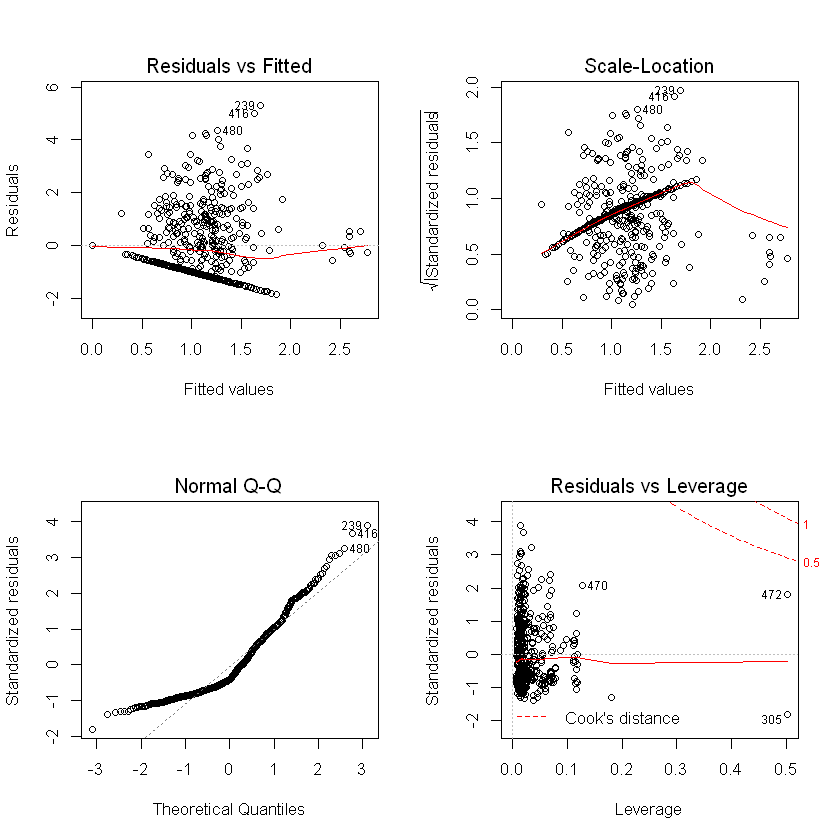

In [47]:
par(mfcol=c(2,2))
plot(fit)

Still, we see significant difference in these plots compared with the 1st model.

- We can still see linear pattern in residual vs fitted plot but many data points seem to be scattered around 0 which is a good sign.
- Scale-Location plot shows that residuals are spread along the ranges of predictors. But we don't see a horizontal line with equally (randomly) spread points.
- Some points like 472 pretty close to being an influencial outliers in the residuals vs leverage plot.

One thing to notice from the exploration part was, the area was not dependent on X and Y values as a number (int). But the area would be dependent on X and Y coordinate as a position, which shows that X and Y variable should be factors rather than numeric values.

In [48]:
fire_df$X <- factor(fire_df$X,levels = c(1,2,3,4,5,6,7,8,9))
fire_df$Y <- factor(fire_df$Y,levels = c(1,2,3,4,5,6,7,8,9))
str(fire_df)

'data.frame':	515 obs. of  15 variables:
 $ X        : Factor w/ 9 levels "1","2","3","4",..: 7 7 7 8 8 8 8 8 8 7 ...
 $ Y        : Factor w/ 9 levels "1","2","3","4",..: 5 4 4 6 6 6 6 6 6 5 ...
 $ month    : Factor w/ 12 levels "jan","feb","mar",..: 3 10 10 3 3 8 8 8 9 9 ...
 $ day      : Factor w/ 7 levels "fri","mon","sat",..: 1 6 3 1 4 4 2 2 6 3 ...
 $ FFMC     : num  86.2 90.6 90.6 91.7 89.3 92.3 92.3 91.5 91 92.5 ...
 $ DMC      : num  26.2 35.4 43.7 33.3 51.3 ...
 $ DC       : num  94.3 669.1 686.9 77.5 102.2 ...
 $ ISI      : num  5.1 6.7 6.7 9 9.6 14.7 8.5 10.7 7 7.1 ...
 $ temp     : num  8.2 18 14.6 8.3 11.4 22.2 24.1 8 13.1 22.8 ...
 $ RH       : int  51 33 33 97 99 29 27 86 63 40 ...
 $ wind     : num  6.7 0.9 1.3 4 1.8 5.4 3.1 2.2 5.4 4 ...
 $ rain     : num  0 0 0 0.2 0 0 0 0 0 0 ...
 $ area     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ tran_FFMC: num  -1.135 -0.0842 -0.0842 0.195 -0.4056 ...
 $ temp_cat : Factor w/ 3 levels "Low","Mid","High": 1 2 1 1 1 2 2 1 1 2 ...


In [49]:
my_fit2 = lm(log(area+1)~.-temp_cat-FFMC, data = fire_df)
summary(my_fit2)


Call:
lm(formula = log(area + 1) ~ . - temp_cat - FFMC, data = fire_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1389 -1.0117 -0.3921  0.7828  5.2081 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.728105   1.535945  -0.474  0.63569   
X2           0.049570   0.260022   0.191  0.84889   
X3          -0.748163   0.301697  -2.480  0.01349 * 
X4          -0.074800   0.273322  -0.274  0.78446   
X5          -0.586408   0.346636  -1.692  0.09136 . 
X6           0.014254   0.285646   0.050  0.96022   
X7          -0.239117   0.298426  -0.801  0.42338   
X8           0.112574   0.370337   0.304  0.76128   
X9           1.557385   0.593984   2.622  0.00902 **
Y3           0.436155   0.323897   1.347  0.17876   
Y4           0.528837   0.276656   1.912  0.05654 . 
Y5           0.353786   0.290288   1.219  0.22355   
Y6           0.396147   0.382088   1.037  0.30036   
Y8           4.220672   1.433107   2.945  0.00339 **
Y9          -1.955421  

We can see the improvement in Adjusted R-squared by 3 percent.

We see many non-significant variables in the model. 

Lets remove unwanted features from this dataset

In [50]:
step(my_fit2)

Start:  AIC=351.77
log(area + 1) ~ (X + Y + month + day + FFMC + DMC + DC + ISI + 
    temp + RH + wind + rain + tran_FFMC + temp_cat) - temp_cat - 
    FFMC

            Df Sum of Sq    RSS    AIC
- day        6     5.669 878.62 343.10
- ISI        1     0.056 873.00 349.80
- RH         1     0.324 873.27 349.96
- temp       1     0.546 873.49 350.09
- rain       1     0.573 873.52 350.11
- tran_FFMC  1     0.627 873.57 350.14
<none>                   872.95 351.77
- wind       1     4.387 877.33 352.35
- DC         1     6.909 879.86 353.83
- month     11    42.843 915.79 354.44
- DMC        1    10.428 883.38 355.89
- Y          6    37.794 910.74 361.60
- X          8    44.945 917.89 361.62

Step:  AIC=343.1
log(area + 1) ~ X + Y + month + DMC + DC + ISI + temp + RH + 
    wind + rain + tran_FFMC

            Df Sum of Sq    RSS    AIC
- ISI        1     0.075 878.69 341.15
- RH         1     0.183 878.80 341.21
- tran_FFMC  1     0.399 879.02 341.34
- rain       1     0.763 879.3


Call:
lm(formula = log(area + 1) ~ X + Y + month + DMC + DC + temp + 
    wind, data = fire_df)

Coefficients:
(Intercept)           X2           X3           X4           X5           X6  
  -0.855277     0.045960    -0.715669    -0.064271    -0.582091     0.028066  
         X7           X8           X9           Y3           Y4           Y5  
  -0.201875     0.120610     1.551284     0.409192     0.505219     0.342473  
         Y6           Y8           Y9     monthfeb     monthmar     monthapr  
   0.359877     4.047648    -2.024430     1.461650     0.868410     1.095197  
   monthmay     monthjun     monthjul     monthaug     monthsep     monthoct  
   1.840661     0.784149     1.571810     1.799268     2.533640     2.488592  
   monthnov     monthdec          DMC           DC         temp         wind  
   0.133758     3.351982     0.004663    -0.002633     0.024167     0.059110  


In [51]:
my_fit2 <- lm(formula = log(area + 1) ~ X + Y + month + DMC + DC + temp + 
    wind, data = fire_df)
summary(my_fit2)


Call:
lm(formula = log(area + 1) ~ X + Y + month + DMC + DC + temp + 
    wind, data = fire_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2124 -0.9799 -0.4139  0.7809  5.3144 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.855277   1.399954  -0.611  0.54153   
X2           0.045960   0.256663   0.179  0.85796   
X3          -0.715669   0.296891  -2.411  0.01630 * 
X4          -0.064271   0.268357  -0.239  0.81082   
X5          -0.582091   0.340958  -1.707  0.08842 . 
X6           0.028066   0.281152   0.100  0.92052   
X7          -0.201875   0.292557  -0.690  0.49050   
X8           0.120610   0.365822   0.330  0.74177   
X9           1.551284   0.586658   2.644  0.00845 **
Y3           0.409192   0.313757   1.304  0.19279   
Y4           0.505219   0.268754   1.880  0.06073 . 
Y5           0.342473   0.283101   1.210  0.22697   
Y6           0.359877   0.370982   0.970  0.33250   
Y8           4.047648   1.408066   2.875  0.00422 **

The adjusted R-squared ($R^2$) value indicates this model explains 7.34% of the variation in burned area which is an improvement by ~ 3 percent.

The F-statistic 2.405 has a p-value < 7.83e-05 - so reject the null hypothesis (the model explains nothing) - the model is useful to some extent.

The p-values for the coefficients shows X3, X9, Y8, Y9, monthdec, DMC, and DC are significant at the 0.05 level.

Warning message:
"not plotting observations with leverage one:
  104, 419, 515"Warning message:
"not plotting observations with leverage one:
  104, 419, 515"

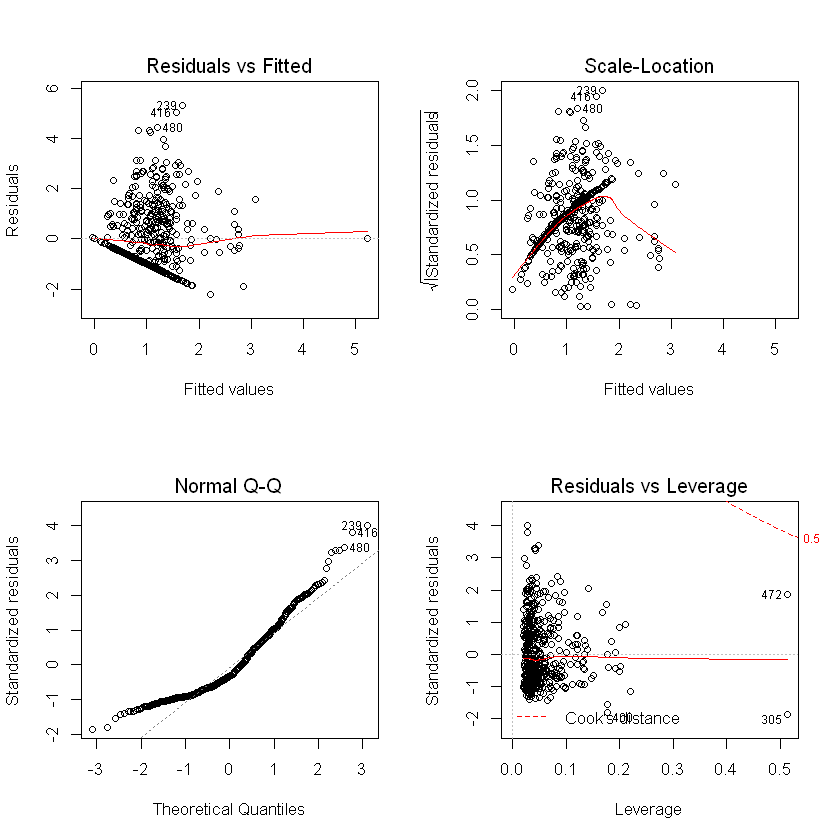

In [52]:
par(mfcol=c(2,2))
plot(my_fit2)

We see that most of the graphs are similar to the previous model except the residuals vs Leverage one.

In that plot, we see that data points are scattered across the 0 level line. There are influencial points but they seem to cancel each other.

From the above models, we see that the it would be better to use non-linear models considering the nature of dataset.

Linear models seem to have hard time capturing the non linearity in the data, resulting in low performance.

### DecisionTree Regressor

Here thee decision tree regressor will split the data for cross validation and calculate the R square.

We will be using ANOVA method to reduce the variance in each node of the tree.

In [53]:
library(rpart)

In [54]:
str(fire_df)

'data.frame':	515 obs. of  15 variables:
 $ X        : Factor w/ 9 levels "1","2","3","4",..: 7 7 7 8 8 8 8 8 8 7 ...
 $ Y        : Factor w/ 9 levels "1","2","3","4",..: 5 4 4 6 6 6 6 6 6 5 ...
 $ month    : Factor w/ 12 levels "jan","feb","mar",..: 3 10 10 3 3 8 8 8 9 9 ...
 $ day      : Factor w/ 7 levels "fri","mon","sat",..: 1 6 3 1 4 4 2 2 6 3 ...
 $ FFMC     : num  86.2 90.6 90.6 91.7 89.3 92.3 92.3 91.5 91 92.5 ...
 $ DMC      : num  26.2 35.4 43.7 33.3 51.3 ...
 $ DC       : num  94.3 669.1 686.9 77.5 102.2 ...
 $ ISI      : num  5.1 6.7 6.7 9 9.6 14.7 8.5 10.7 7 7.1 ...
 $ temp     : num  8.2 18 14.6 8.3 11.4 22.2 24.1 8 13.1 22.8 ...
 $ RH       : int  51 33 33 97 99 29 27 86 63 40 ...
 $ wind     : num  6.7 0.9 1.3 4 1.8 5.4 3.1 2.2 5.4 4 ...
 $ rain     : num  0 0 0 0.2 0 0 0 0 0 0 ...
 $ area     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ tran_FFMC: num  -1.135 -0.0842 -0.0842 0.195 -0.4056 ...
 $ temp_cat : Factor w/ 3 levels "Low","Mid","High": 1 2 1 1 1 2 2 1 1 2 ...


In [55]:
fit <- rpart(log(area+1) ~ X+Y+month+DMC+temp+DC+ISI+RH+day+FFMC+wind+rain, method="anova", data=fire_df,
             control = list(minsplit = 4, maxdepth = 4, cp=0.01))
summary(fit)

Call:
rpart(formula = log(area + 1) ~ X + Y + month + DMC + temp + 
    DC + ISI + RH + day + FFMC + wind + rain, data = fire_df, 
    method = "anova", control = list(minsplit = 4, maxdepth = 4, 
        cp = 0.01))
  n= 515 

          CP nsplit rel error   xerror       xstd
1 0.02299189      0 1.0000000 1.006732 0.07573787
2 0.01893317      1 0.9770081 1.053045 0.07640211
3 0.01613102      3 0.9391418 1.066160 0.07780978
4 0.01402669      4 0.9230108 1.084103 0.07970357
5 0.01000000      5 0.9089841 1.087441 0.08210907

Variable importance
    X   DMC month  temp  FFMC    DC     Y   ISI    RH 
   28    27    21     9     5     5     3     3     2 

Node number 1: 515 observations,    complexity param=0.02299189
  mean=1.11534, MSE=1.954608 
  left son=2 (85 obs) right son=3 (430 obs)
  Primary splits:
      X     splits as  RRLRLRRRR,    improve=0.02299189, (0 missing)
      month splits as  LLLLRLLLLLLR, improve=0.01954192, (0 missing)
      temp  < 5.2    to the right,   improve=0

Position X, DMC and month seems to be very important features for this model. This model developed is simple with less  

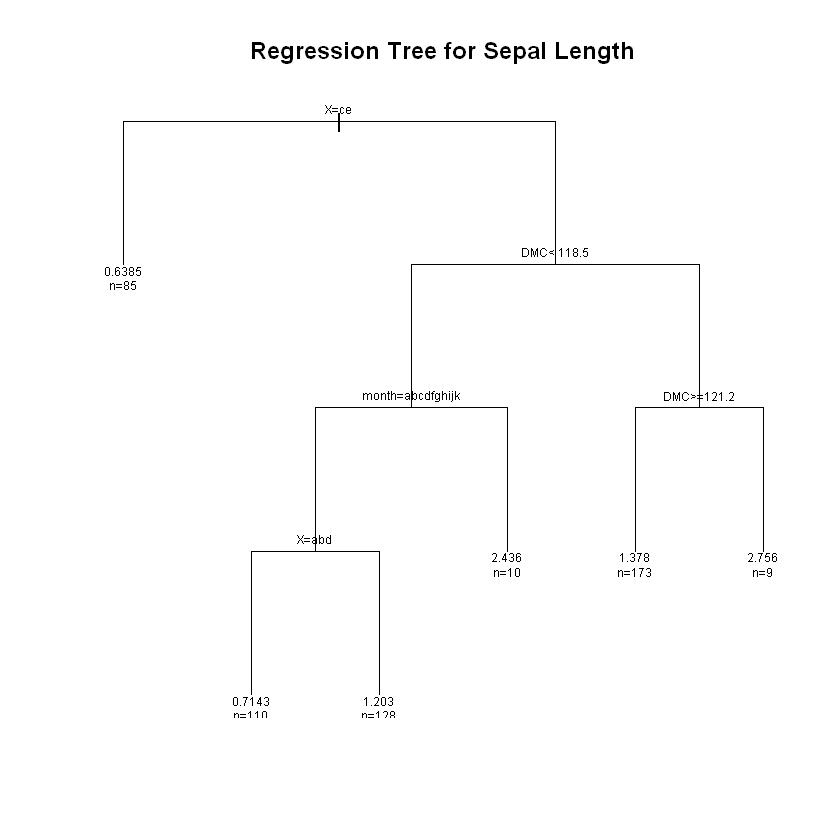

In [56]:
plot(fit, uniform=TRUE, 
 main="Regression Tree for Sepal Length")
 text(fit, use.n=TRUE, cex = .6)

We can see that the first split has been made based on X. Then the next split has been made based on value of DMC. And so this model considers these variables as most important.


Regression tree:
rpart(formula = log(area + 1) ~ X + Y + month + DMC + temp + 
    DC + ISI + RH + day + FFMC + wind + rain, data = fire_df, 
    method = "anova", control = list(minsplit = 4, maxdepth = 4, 
        cp = 0.01))

Variables actually used in tree construction:
[1] DMC   month X    

Root node error: 1006.6/515 = 1.9546

n= 515 

        CP nsplit rel error xerror     xstd
1 0.022992      0   1.00000 1.0067 0.075738
2 0.018933      1   0.97701 1.0530 0.076402
3 0.016131      3   0.93914 1.0662 0.077810
4 0.014027      4   0.92301 1.0841 0.079704
5 0.010000      5   0.90898 1.0874 0.082109


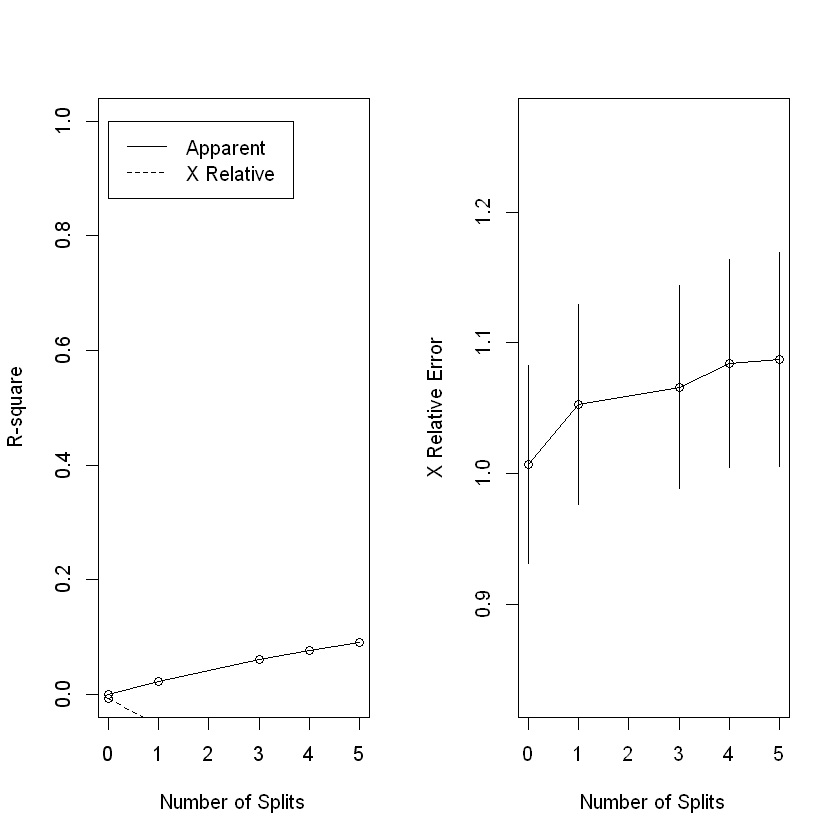

In [57]:
par(mfrow=c(1,2)) 
rsq.rpart(fit)

Here we can see that r square increases with increase in number of splits. However, it is important to notice that X relative error remains almost constant with increase in number of splits.

We can make this model a bit more complex by adding increasing the depth

In [58]:
fit <- rpart(log(area+1) ~ X+Y+month+DMC+temp+DC+ISI+RH+day+FFMC+wind+rain, method="anova", data=fire_df,
             control = list(minsplit = 6, maxdepth = 8, cp=0.01))
summary(fit)

Call:
rpart(formula = log(area + 1) ~ X + Y + month + DMC + temp + 
    DC + ISI + RH + day + FFMC + wind + rain, data = fire_df, 
    method = "anova", control = list(minsplit = 6, maxdepth = 8, 
        cp = 0.01))
  n= 515 

          CP nsplit rel error   xerror       xstd
1 0.02299189      0 1.0000000 1.001986 0.07540123
2 0.01893317      1 0.9770081 1.074480 0.08107797
3 0.01613102      3 0.9391418 1.095857 0.08162493
4 0.01402669      4 0.9230108 1.149994 0.08656690
5 0.01309087      5 0.9089841 1.204213 0.09055366
6 0.01291525     11 0.8295460 1.200010 0.08855983
7 0.01070482     13 0.8037155 1.218065 0.08924764
8 0.01000000     14 0.7930107 1.269644 0.09094207

Variable importance
 temp    RH     X   DMC month     Y   day    DC  FFMC   ISI  wind 
   19    18    14    13     9     7     7     5     3     2     2 

Node number 1: 515 observations,    complexity param=0.02299189
  mean=1.11534, MSE=1.954608 
  left son=2 (85 obs) right son=3 (430 obs)
  Primary splits:
      X   

- In this summary, we can see that temperature, RH are considered very important factor for modelling. THis is obvious as fire area is dependent on temperature.

- Although relative error decreases, std error remains fluctuate so the model is not good enough for prediction.


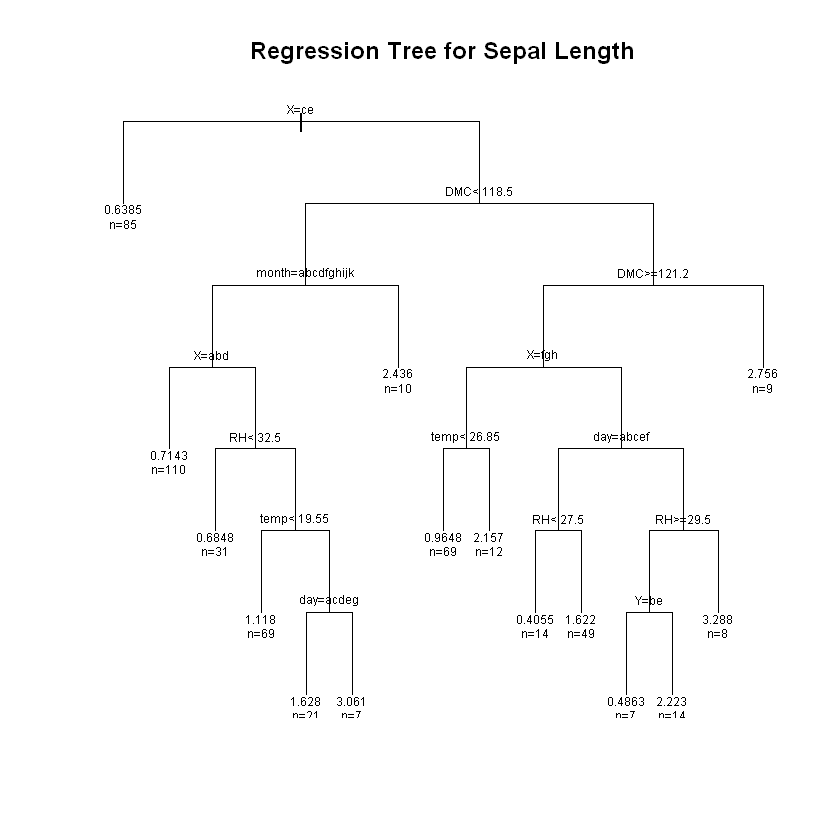

In [59]:
plot(fit, uniform=TRUE, 
 main="Regression Tree for Sepal Length")
 text(fit, use.n=TRUE, cex = .6)


Regression tree:
rpart(formula = log(area + 1) ~ X + Y + month + DMC + temp + 
    DC + ISI + RH + day + FFMC + wind + rain, data = fire_df, 
    method = "anova", control = list(minsplit = 6, maxdepth = 8, 
        cp = 0.01))

Variables actually used in tree construction:
[1] day   DMC   month RH    temp  X     Y    

Root node error: 1006.6/515 = 1.9546

n= 515 

        CP nsplit rel error xerror     xstd
1 0.022992      0   1.00000 1.0020 0.075401
2 0.018933      1   0.97701 1.0745 0.081078
3 0.016131      3   0.93914 1.0959 0.081625
4 0.014027      4   0.92301 1.1500 0.086567
5 0.013091      5   0.90898 1.2042 0.090554
6 0.012915     11   0.82955 1.2000 0.088560
7 0.010705     13   0.80372 1.2181 0.089248
8 0.010000     14   0.79301 1.2696 0.090942


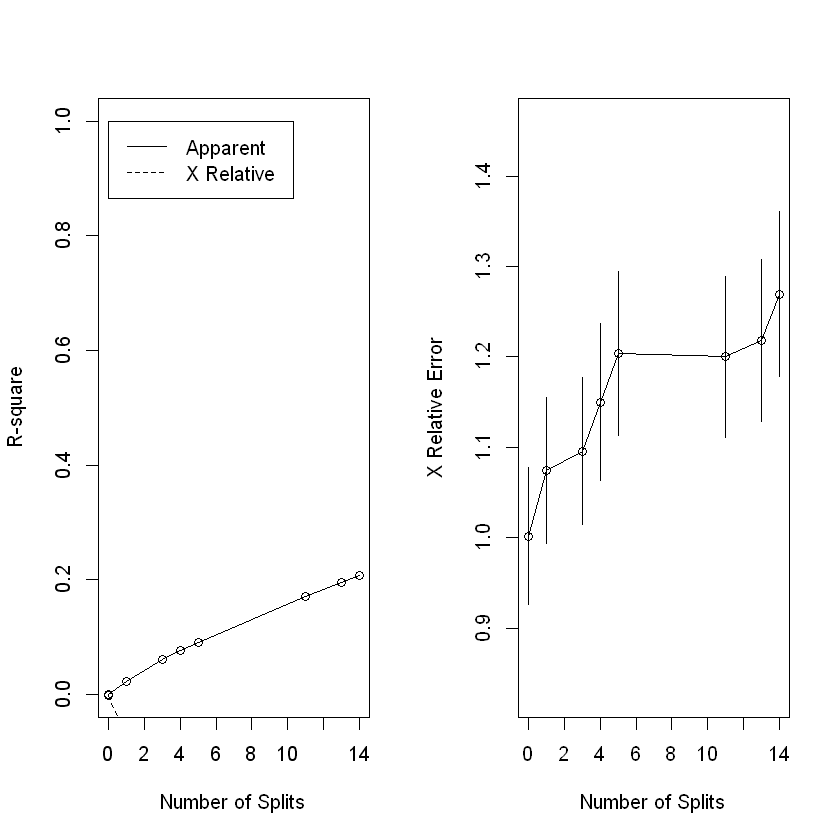

In [60]:
par(mfrow=c(1,2)) 
rsq.rpart(fit)

We see higher value of R-square compared with previous model but the relative error increases with the increase in number of splits.

This means that model is performing okay and not generalizing well enough based on different splits of data.

#### Searching for the best optimal parameters,

In [61]:
hyper_grid <- expand.grid(
  minsplit = seq(5, 16, 1),
  maxdepth = seq(3, 10, 1)
)

In [62]:
nrow(hyper_grid)

[1] 96

In [63]:
models <- list()

for (i in 1:nrow(hyper_grid)) {
  
  # get minsplit, maxdepth values at row i
  minsplit <- hyper_grid$minsplit[i]
  maxdepth <- hyper_grid$maxdepth[i]

  # train a model and store in the list
  models[[i]] <- rpart(log(area+1) ~ X+Y+month+DMC+temp+DC+ISI+RH+day+FFMC+wind+rain, 
                       method="anova", 
                       data=fire_df,
                       control = list(minsplit = minsplit, maxdepth = maxdepth)
                      )
}


In [64]:
# function to get optimal cp
get_cp <- function(x) {
  min    <- which.min(x$cptable[, "xerror"])
  cp <- x$cptable[min, "CP"] 
}

# function to get minimum error
get_min_error <- function(x) {
  min    <- which.min(x$cptable[, "xerror"])
  xerror <- x$cptable[min, "xerror"] 
}

hyper_grid %>%
  mutate(
    cp    = purrr::map_dbl(models, get_cp),
    error = purrr::map_dbl(models, get_min_error)
    ) %>%
  arrange(error) %>%
  top_n(-5, wt = error)

minsplit,maxdepth,cp,error
5,3,0.01000000,0.9906422
6,9,0.02299189,1.0010581
7,3,0.02299189,1.0011760
9,9,0.02299189,1.0011877
13,6,0.02299189,1.0012081


In [65]:
fit <- rpart(log(area+1) ~ X+Y+month+DMC+temp+RH+day+DC+FFMC+wind+ISI, method="anova", data=fire_df,
             control = list(minsplit = 14, maxdepth = 14, cp=0.01))
summary(fit)

Call:
rpart(formula = log(area + 1) ~ X + Y + month + DMC + temp + 
    RH + day + DC + FFMC + wind + ISI, data = fire_df, method = "anova", 
    control = list(minsplit = 14, maxdepth = 14, cp = 0.01))
  n= 515 

          CP nsplit rel error   xerror       xstd
1 0.02299189      0 1.0000000 1.002929 0.07521570
2 0.01893317      1 0.9770081 1.044969 0.07786003
3 0.01613102      3 0.9391418 1.125483 0.08400532
4 0.01402669      4 0.9230108 1.152566 0.08810364
5 0.01309087      5 0.9089841 1.178701 0.08915778
6 0.01291525     11 0.8295460 1.214619 0.09081687
7 0.01070482     13 0.8037155 1.250306 0.09322679
8 0.01000000     14 0.7930107 1.317610 0.09638148

Variable importance
 temp    RH     X   DMC month     Y   day    DC  FFMC   ISI  wind 
   19    19    14    13     9     7     7     5     3     2     2 

Node number 1: 515 observations,    complexity param=0.02299189
  mean=1.11534, MSE=1.954608 
  left son=2 (85 obs) right son=3 (430 obs)
  Primary splits:
      X     splits as  R

Even after grid search, we don't see any set of parameters which improves the performance considerably compared to previous model.

In [66]:
sprintf('R-squared for Decision tree is %f',sum((predict(fit)-mean(log(fire_df$area+1)))^2)/sum((log(fire_df$area+1)-mean(log(fire_df$area+1)))^2))

[1] "R-squared for Decision tree is 0.206989"

#### Bagging Trees model

Bagging trees model is a common method used for fitting predictive models with differnt parameters and allows combining them using ensembling appraoch to get aggregated prediction.

In this approach, original dataset is sampled by bootstrapping. And average is taken over all models built on these samples.

In [67]:
library(ipred)
library(caret)

Loading required package: lattice


In [68]:
bagg <- bagging(log(area+1)~X+Y+month+DMC+temp+DC+ISI+RH+day+FFMC+wind+rain, 
                  nbagg = 15,
                method='treebag',data=fire_df,coob=TRUE)
bagg


Bagging regression trees with 15 bootstrap replications 

Call: bagging.data.frame(formula = log(area + 1) ~ X + Y + month + 
    DMC + temp + DC + ISI + RH + day + FFMC + wind + rain, data = fire_df, 
    nbagg = 15, method = "treebag", coob = TRUE)

Out-of-bag estimate of root mean squared error:  1.4945 


Here we have created 100 bootstrap replications, and we get 1.4299 as rmse, which seems better in terms of performance.

We create 10 cross validated mini folds for calculating the error measure here. 

Here, more the trees, better the performace as we average over higher variance trees. [Read more](https://bradleyboehmke.github.io/HOML/bagging.html)

In [69]:
sprintf('R-squared for Bagging tree is %f',sum((predict(bagg)-mean(log(fire_df$area+1)))^2)/sum((log(fire_df$area+1)-mean(log(fire_df$area+1)))^2))

[1] "R-squared for Bagging tree is 0.168430"

In [70]:
summary(bagg)

       Length Class      Mode   
y      515    -none-     numeric
X       12    data.frame list   
mtrees  15    -none-     list   
OOB      1    -none-     logical
comb     1    -none-     logical
err      1    -none-     numeric
call     6    -none-     call   

### LightGBM

In [71]:
library(lightgbm)
library(methods)

Loading required package: R6
Warning message:
"package 'R6' was built under R version 3.5.3"
Attaching package: 'lightgbm'

The following object is masked from 'package:dplyr':

    slice



In [72]:
library(data.table)
library(Matrix)
set.seed(257)

Warning message:
"package 'data.table' was built under R version 3.5.3"
Attaching package: 'data.table'

The following objects are masked from 'package:reshape2':

    dcast, melt

The following objects are masked from 'package:dplyr':

    between, first, last



In [73]:
setdiff(colnames(fire_df), c("temp_cat", "area"))

[1] "X"         "Y"         "month"     "day"       "FFMC"      "DMC"      
 [7] "DC"        "ISI"       "temp"      "RH"        "wind"      "rain"     
[13] "tran_FFMC"

In [74]:
varnames = setdiff(colnames(fire_df), c("temp_cat", "tran_FFMC","area"))

train_sparse = Matrix(as.matrix(fire_df[, setdiff(colnames(fire_df), c("temp_cat", "tran_FFMC","area"))]), sparse=TRUE)

y_train  = log(fire_df[,'area']+1)

# lgb.train = lgb.Dataset(data=train_sparse, label=y_train)

Warning message in storage.mode(from) <- "double":
"NAs introduced by coercion"

In [75]:
print("Training lightgbm with sparseMatrix")

bst <- lightgbm(
    metric="rmse",
    data = train_sparse,
    label = y_train,
    num_leaves = 25,
    learning_rate = 0.001,
    nrounds = 200,
    early_stopping_rounds=10,
    objective = "regression"
)

# check the output logs in R studio and copy it here. 

[1] "Training lightgbm with sparseMatrix"
[1]:	train's rmse:1.39788 
[2]:	train's rmse:1.3977 
[3]:	train's rmse:1.39751 
[4]:	train's rmse:1.39732 
[5]:	train's rmse:1.39713 
[6]:	train's rmse:1.39695 
[7]:	train's rmse:1.39676 
[8]:	train's rmse:1.39657 
[9]:	train's rmse:1.39639 
[10]:	train's rmse:1.3962 
[11]:	train's rmse:1.39602 
[12]:	train's rmse:1.39583 
[13]:	train's rmse:1.39565 
[14]:	train's rmse:1.39547 
[15]:	train's rmse:1.39528 
[16]:	train's rmse:1.39508 
[17]:	train's rmse:1.3949 
[18]:	train's rmse:1.39471 
[19]:	train's rmse:1.39451 
[20]:	train's rmse:1.39433 
[21]:	train's rmse:1.39415 
[22]:	train's rmse:1.39395 
[23]:	train's rmse:1.39376 
[24]:	train's rmse:1.39358 
[25]:	train's rmse:1.39338 
[26]:	train's rmse:1.3932 
[27]:	train's rmse:1.39302 
[28]:	train's rmse:1.39282 
[29]:	train's rmse:1.39264 
[30]:	train's rmse:1.39247 
[31]:	train's rmse:1.39227 
[32]:	train's rmse:1.39209 
[33]:	train's rmse:1.39191 
[34]:	train's rmse:1.39171 
[35]:	train's rmse:

[LightGBM] [Info] Total Bins 599

[LightGBM] [Info] Number of data: 515, number of used features: 9

[LightGBM] [Info] Start training from score 1.115340

We are getting around 1.363 rmse on training data.

## 4. Model Comparsion<a class="anchor" id="sec_4"></a>

For model comparision, we will compare the root mean squared error (RMSE), for all models developed above.

We will calculate this metric based on the K fold cross validation strategy.

### 4.1  Multilinear regression

In [76]:
library(caret)

In [77]:
# define training control
set.seed(20)
train_control <- trainControl(method="repeatedcv", number=10, repeats=3) # same result for repeats=10

In [78]:
model <- train(log(area + 1) ~ X + Y + month + DMC + DC + temp + wind, 
               data = fire_df, method = "lm",
               trControl = train_control)

# Summarize the results
print(model)

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdat

Linear Regression 

515 samples
  7 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 465, 463, 464, 463, 465, 463, ... 
Resampling results:

  RMSE     Rsquared    MAE  
  1.41533  0.04126888  1.134

Tuning parameter 'intercept' was held constant at a value of TRUE


Here, we get RMSE of **1.415**, and Rsquared as **0.0412**

### 4.2 Decision Tree model

In [79]:
library(plyr)

Warning message:
"package 'plyr' was built under R version 3.5.3"------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: 'plyr'

The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



In [80]:
fit <- rpart(log(area+1) ~ X+Y+month+DMC+temp+DC+ISI+RH+day+FFMC+wind+rain, method="anova", data=fire_df,
             control = list(minsplit = 14, maxdepth = 14, cp=0.01))

In [81]:
set.seed(20)
form <- ""
folds <- split(fire_df, cut(sample(1:nrow(fire_df)),10))
errs <- rep(NA, length(folds))
test_vector <- c()
sq_sum = 0
for (i in 1:length(folds)){
    test <- ldply(folds[i], data.frame)
    train <- ldply(folds[-i], data.frame)
    tmp.model <- rpart(log(area+1) ~ X+Y+month+DMC+temp+DC+ISI+RH+day+FFMC+wind+rain, method="anova", data=train,
             control = list(minsplit = 14, maxdepth = 14, cp=0.01))
    tmp.predict <- predict(tmp.model, newdata = test)
    test_vector <- c(test_vector,tmp.predict)
    sq_sum = sq_sum + sum((tmp.predict - log(test$area+1))^2)    
}
sprintf("average error using k-fold cross-validation: %f percent", sqrt(sq_sum/515))

[1] "average error using k-fold cross-validation: 1.569565 percent"

### 4.3 Bagging model

In [82]:
bagg <- bagging(log(area+1)~X+Y+month+DMC+temp+DC+ISI+RH+day+FFMC+wind+rain, 
                nbagg = 15,trControl = train_control,
                method='treebag',data=fire_df,coob=TRUE)

print(bagg)


Bagging regression trees with 15 bootstrap replications 

Call: bagging.data.frame(formula = log(area + 1) ~ X + Y + month + 
    DMC + temp + DC + ISI + RH + day + FFMC + wind + rain, data = fire_df, 
    nbagg = 15, trControl = train_control, method = "treebag", 
    coob = TRUE)

Out-of-bag estimate of root mean squared error:  1.4729 



### 4.4 LightGBM

In [83]:
params <- list( objective = "regression", metric="rmse")

set.seed(23242)
nrounds <-15L
bst <- lgb.cv(
    params,
    data = train_sparse,
    label = y_train,
    num_leaves = 25,
    learning_rate = 0.001,
    nrounds = 200,
    early_stopping_rounds=10,
    nfolds= 10,
    nrounds
)


[1]:	valid's rmse:1.37508+0.276522 
[2]:	valid's rmse:1.37505+0.276588 
[3]:	valid's rmse:1.37501+0.276657 
[4]:	valid's rmse:1.37497+0.276725 
[5]:	valid's rmse:1.37494+0.276791 
[6]:	valid's rmse:1.37489+0.27686 
[7]:	valid's rmse:1.37485+0.276929 
[8]:	valid's rmse:1.37482+0.276999 
[9]:	valid's rmse:1.37481+0.277039 
[10]:	valid's rmse:1.37477+0.277107 
[11]:	valid's rmse:1.37473+0.277172 
[12]:	valid's rmse:1.3747+0.277238 
[13]:	valid's rmse:1.37468+0.277279 
[14]:	valid's rmse:1.37465+0.277336 
[15]:	valid's rmse:1.37462+0.27739 
[16]:	valid's rmse:1.37459+0.277452 
[17]:	valid's rmse:1.37458+0.277479 
[18]:	valid's rmse:1.37455+0.277537 
[19]:	valid's rmse:1.37451+0.277592 
[20]:	valid's rmse:1.3745+0.277624 
[21]:	valid's rmse:1.37446+0.277675 
[22]:	valid's rmse:1.37444+0.277725 
[23]:	valid's rmse:1.37442+0.277759 
[24]:	valid's rmse:1.3744+0.277817 
[25]:	valid's rmse:1.37438+0.27785 
[26]:	valid's rmse:1.37436+0.27791 
[27]:	valid's rmse:1.37433+0.277966 
[28]:	valid's rms

In [84]:
bst$best_iter

[1] 143

We are getting best results at 143 epochs so we will run it till 143.

In [85]:
set.seed(23242)
bst <- lgb.cv(
    params,
    data = train_sparse,
    label = y_train,
    num_leaves = 25,
    learning_rate = 0.001,
    nrounds = 143,
    nfolds= 10,
    nrounds,
    nthreads=1
)

[1]:	valid's rmse:1.37508+0.276522 
[2]:	valid's rmse:1.37505+0.276588 
[3]:	valid's rmse:1.37501+0.276657 
[4]:	valid's rmse:1.37497+0.276725 
[5]:	valid's rmse:1.37494+0.276791 
[6]:	valid's rmse:1.37489+0.27686 
[7]:	valid's rmse:1.37485+0.276929 
[8]:	valid's rmse:1.37482+0.276999 
[9]:	valid's rmse:1.37481+0.277039 
[10]:	valid's rmse:1.37477+0.277107 
[11]:	valid's rmse:1.37473+0.277172 
[12]:	valid's rmse:1.3747+0.277238 
[13]:	valid's rmse:1.37468+0.277279 
[14]:	valid's rmse:1.37465+0.277336 
[15]:	valid's rmse:1.37462+0.27739 
[16]:	valid's rmse:1.37459+0.277452 
[17]:	valid's rmse:1.37458+0.277479 
[18]:	valid's rmse:1.37455+0.277537 
[19]:	valid's rmse:1.37451+0.277592 
[20]:	valid's rmse:1.3745+0.277624 
[21]:	valid's rmse:1.37446+0.277675 
[22]:	valid's rmse:1.37444+0.277725 
[23]:	valid's rmse:1.37442+0.277759 
[24]:	valid's rmse:1.3744+0.277817 
[25]:	valid's rmse:1.37438+0.27785 
[26]:	valid's rmse:1.37436+0.27791 
[27]:	valid's rmse:1.37433+0.277966 
[28]:	valid's rms

We got validation rmse of almost **1.37313** which is better than the other models

## 5. Variable Identification and Explanation <a class="anchor" id="sec_5"></a>

Above, you can see experiments on linear models. However, better variable selection can be done by following methods.  

### Subset Selection Method for linear models

We will look at subset selection method for linear regression

In [86]:
library(leaps)

In [87]:
regfit.full <- regsubsets(log(area+1)~.-temp_cat-FFMC, data = fire_df, nvmax=25)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2  linear dependencies found"

Reordering variables and trying again:


In [88]:
reg.summary <- summary(regfit.full)
reg.summary

Subset selection object
Call: regsubsets.formula(log(area + 1) ~ . - temp_cat - FFMC, data = fire_df, 
    nvmax = 25)
41 Variables  (and intercept)
          Forced in Forced out
X2            FALSE      FALSE
X3            FALSE      FALSE
X4            FALSE      FALSE
X5            FALSE      FALSE
X6            FALSE      FALSE
X7            FALSE      FALSE
X8            FALSE      FALSE
X9            FALSE      FALSE
Y2            FALSE      FALSE
Y3            FALSE      FALSE
Y4            FALSE      FALSE
Y5            FALSE      FALSE
Y6            FALSE      FALSE
Y8            FALSE      FALSE
monthfeb      FALSE      FALSE
monthmar      FALSE      FALSE
monthapr      FALSE      FALSE
monthmay      FALSE      FALSE
monthjun      FALSE      FALSE
monthjul      FALSE      FALSE
monthaug      FALSE      FALSE
monthsep      FALSE      FALSE
monthoct      FALSE      FALSE
monthnov      FALSE      FALSE
monthdec      FALSE      FALSE
daymon        FALSE      FALSE
daysat        

An asterisk indicates that a variable in the corresponding column is included in the model. For example, the best model only contains 1 variables, only contains **X3** which has * besides it.


We can examine these outputs to identify the best overall model. First, let's find the best overall model using Mallow's CP.

[1] 11

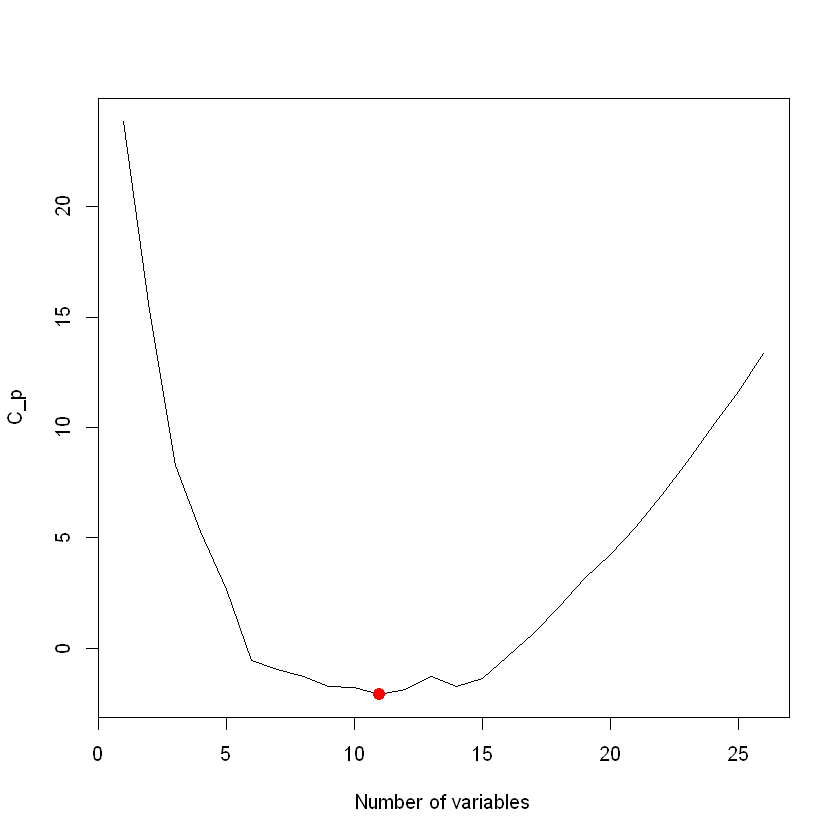

In [89]:
plot(reg.summary$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
mincp = which.min(reg.summary$cp)
points(mincp, reg.summary$cp[mincp], col = "red", cex = 2, pch = 20)
mincp

The plot suggests that the best overall model is a model with 3 variables.

The three variables and their coefficients are:

In [90]:
coef(regfit.full, mincp)

(Intercept)          X3          X5          X9          Y2    monthfeb 
 0.95701823 -0.66878997 -0.46275528  0.35560491 -0.44863746  0.05119623 
   monthmar    monthapr    monthnov      daysat        wind   tran_FFMC 
-0.37426045 -0.12774410 -1.17549207  0.13371968  0.07591492  0.04846257

Similarly, we can use some other criteria, such as BIC and RSS.

We will see BIC first.

(Intercept)          X3    monthfeb      daysat 
 1.16353783 -0.62758403 -0.03783158  0.12442967

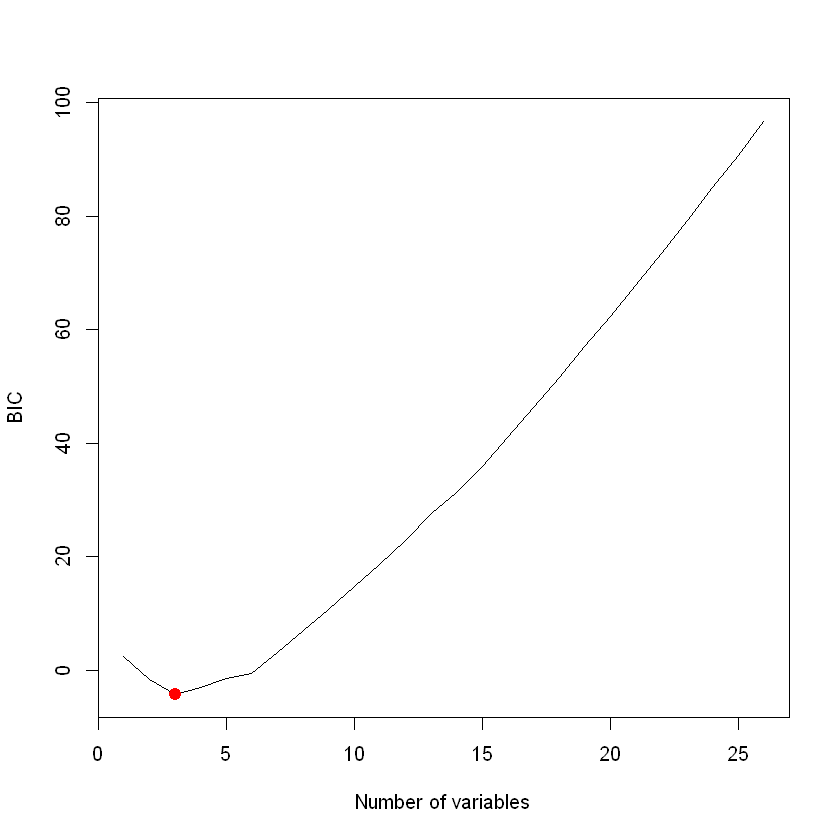

In [91]:
plot(reg.summary$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
minbic = which.min(reg.summary$bic)
points(minbic, reg.summary$bic[minbic], col = "red", cex = 2, pch = 20)
coef(regfit.full, minbic)

BIC give way different model than the one we saw from mallow's cp.

Lets see R2,

(Intercept)           X3           X5           X9           Y2     monthfeb 
 0.409820315 -0.640011736 -0.464278208  0.380613848 -0.370750159  0.503443289 
    monthmar     monthapr     monthsep     monthoct     monthnov     monthdec 
-0.029519723  0.279678406  0.314993382 -0.005969998 -0.736038654  1.773868552 
      daysat          ISI         temp         wind    tran_FFMC 
 0.163910610 -0.012847095  0.024779348  0.070910197  0.106706935

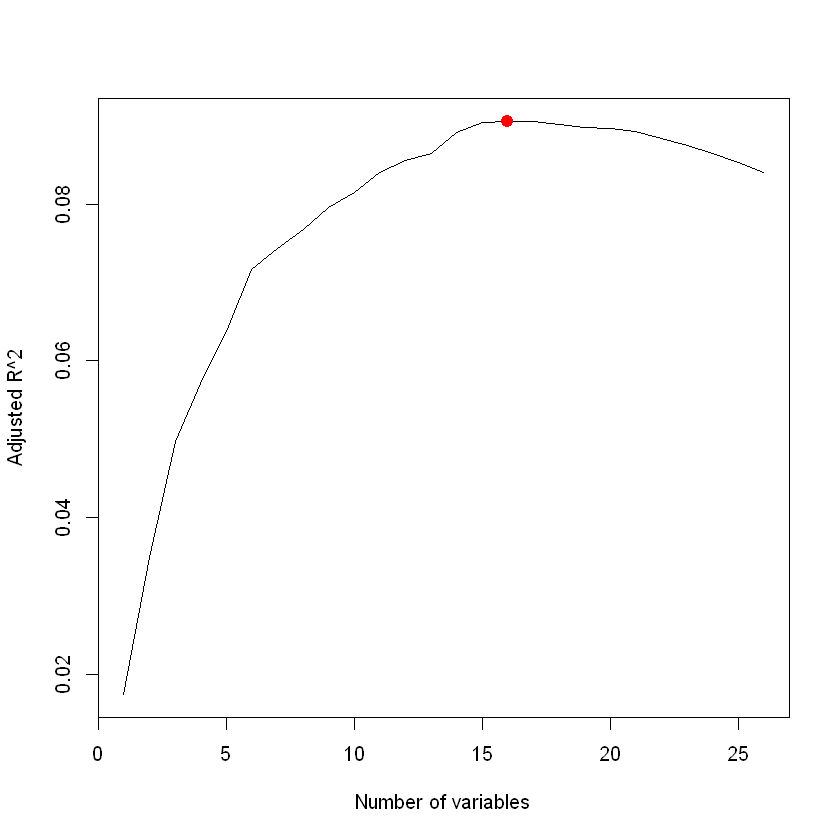

In [92]:
plot(reg.summary$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
max_adjr2 = which.max(reg.summary$adjr2)
points(max_adjr2, reg.summary$adjr2[max_adjr2 ], col = "red", cex = 2, pch = 20)
coef(regfit.full, max_adjr2)

We see that, this criteria gives best model with 16 overall parameter, which are described with their coefficients above.

Lastly, lets look at RSS criteria.

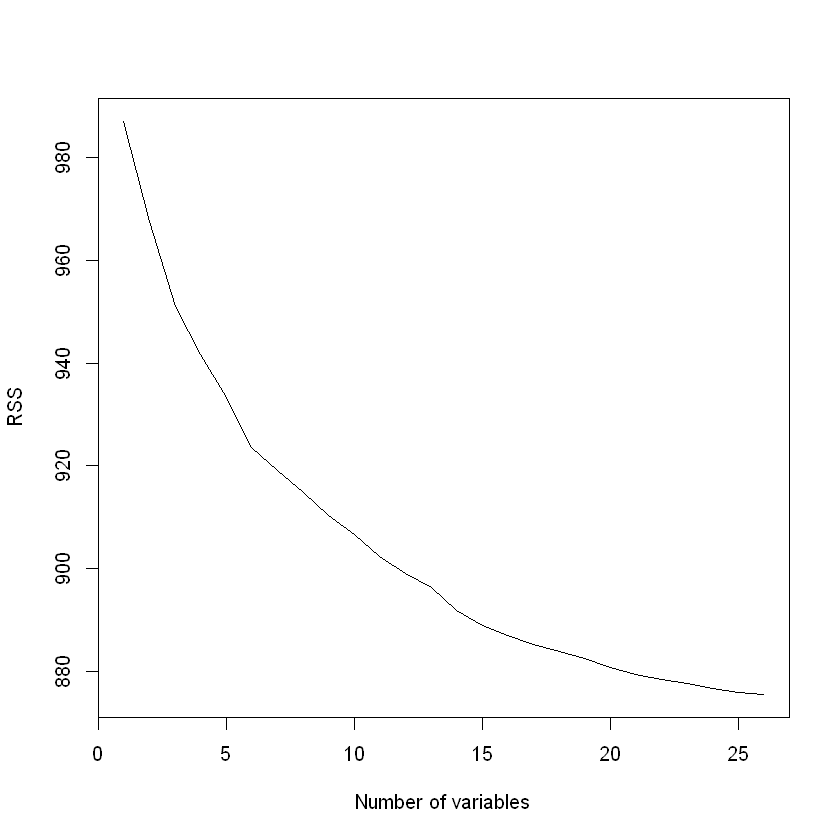

In [93]:
plot(reg.summary$rss, xlab = "Number of variables", ylab = "RSS", type = "l")

We observe that RSS decreases exponentially with increase in number of variables.

As results from all above selection process are different, we find most common features among all above selection process.

So we can conclude that X5,X9,Y2,monthfeb,monthmar,monthapr,monthnov,daysat,wind,tran_FFMC are important variables based on commonality between each of the above methods

### LASSO

Till now, we performed feature selection using subsets method, now we will use  LASSO which automatically selects the features. Depending on the shrinkage parameter, Lasso regularizes the coefficient in a way such that the estimated coefficients can be shrunk toward zero.

In [94]:
library(glmnet)

Loading required package: foreach
Loaded glmnet 2.0-16



In [95]:
xmat <- model.matrix(log(area+1)~.-temp_cat-FFMC, data = fire_df)
xmat <- xmat[, -1]

We will use cross validation to select best $\lambda$

In [96]:
cv.lasso <- cv.glmnet(xmat, log(fire_df$area+1), alpha = 1)

If <font color="orange">alpha</font> is set to 0, a Ridge regression model is going to be fit. The default number of folds used is 10. You can also set the number of folds by specifying the value of <font color="orange">nfolds</font>.

Lets plot the MSE as a function of the logarithm of $\lambda$ with error bars.

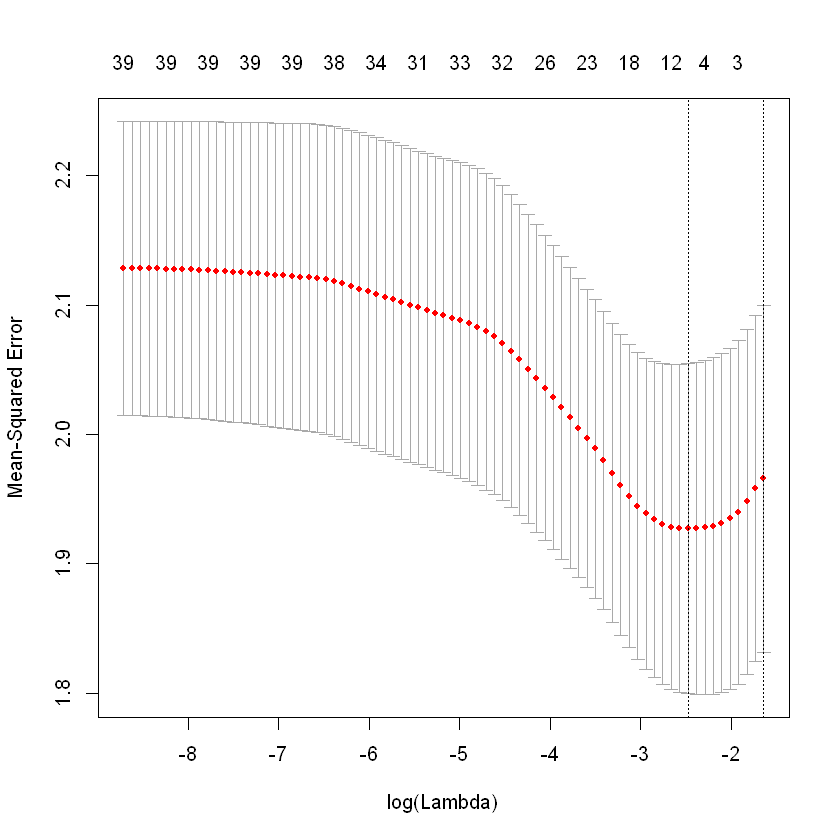

In [97]:
plot(cv.lasso)

In [98]:
bestlam <- cv.lasso$lambda.min
sprintf('Best lambda value for cv is %f',bestlam)

[1] "Best lambda value for cv is 0.084220"

In [99]:
fit.lasso <- glmnet(xmat, log(fire_df$area+1), alpha = 1)
predict(fit.lasso, s = bestlam, type = "coefficients")[1:42, ]

(Intercept)            X2            X3            X4            X5 
 1.0856052374  0.0000000000 -0.3517546026  0.0000000000 -0.0065093767 
           X6            X7            X8            X9            Y2 
 0.0000000000  0.0000000000  0.0000000000  0.0000000000 -0.0375272421 
           Y3            Y4            Y5            Y6            Y7 
 0.0000000000  0.0000000000  0.0000000000  0.0000000000  0.0000000000 
           Y8            Y9      monthfeb      monthmar      monthapr 
 2.1961732663  0.0000000000  0.0000000000 -0.0049360537  0.0000000000 
     monthmay      monthjun      monthjul      monthaug      monthsep 
 0.0000000000  0.0000000000  0.0000000000  0.0000000000  0.0813019158 
     monthoct      monthnov      monthdec        daymon        daysat 
 0.0000000000  0.0000000000  0.8878968217  0.0000000000  0.0000000000 
       daysun        daythu        daytue        daywed           DMC 
 0.0000000000  0.0000000000  0.0000000000  0.0000000000  0.0001239484 
           DC           ISI          temp            RH          wind 
 0.0000000000  0.0000000000  0.0005656558  0.0000000000  0.0000000000 
         rain     tran_FFMC 
 0.0000000000  0.0000000000

The above result shows that 33 of the 42 coefficient estimates are exactly zero. So the lasso model with $\lambda$ chosen by cross-validation contains only **nine** variable, besides the intercept. 

## Tree based Non-linear models

Varaiable selection in non-linear tree based models, eg. Decision tree for Regression is done based on Mean Square Error (MSE) Impurity.

Calulation for Feature importance is done consideting decrease in node impurity weighted by the probability of reaching that node. 

The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples.

If the value at each node is higher, the feature is more important.

**feature_importance += number_of_samples_at_parent_where_feature_is_used * impurity_at_parent-left_child_samples***
                            **impurity_leftnode-right_child_samples * impurity_rightnode**

Impurity can be written as:

**normalized_importance = feature_importance/number_of_samples_root_node(total number of samples)**

In [100]:
fit <- rpart(log(area+1) ~ ., method="anova", data=fire_df,
             control = list(minsplit = 14, maxdepth = 14, cp=0.01))
summary(fit)

Call:
rpart(formula = log(area + 1) ~ ., data = fire_df, method = "anova", 
    control = list(minsplit = 14, maxdepth = 14, cp = 0.01))
  n= 515 

          CP nsplit rel error   xerror       xstd
1 0.02299189      0 1.0000000 1.002226 0.07528658
2 0.01893317      1 0.9770081 1.077643 0.07828243
3 0.01613102      3 0.9391418 1.082304 0.07860699
4 0.01402669      4 0.9230108 1.123982 0.08339972
5 0.01309087      5 0.9089841 1.162088 0.08367428
6 0.01291525     11 0.8295460 1.163496 0.08395236
7 0.01070482     13 0.8037155 1.186441 0.08714532
8 0.01000000     14 0.7930107 1.241026 0.09054649

Variable importance
     temp        RH         X       DMC     month         Y       day        DC 
       18        17        13        12         9         7         6         5 
 temp_cat      FFMC tran_FFMC      wind       ISI 
        4         3         2         1         1 

Node number 1: 515 observations,    complexity param=0.02299189
  mean=1.11534, MSE=1.954608 
  left son=2 (85 obs) 

So, from the above model, we got variable importance measures as follows:

Variable importance

     temp        RH         X       DMC     month         Y       day        DC 
       18        17        13        12         9         7         6         5 
  
  
    temp_cat      FFMC tran_FFMC      wind       ISI 
        4           3         2         1         1 

So, the selection of variables can be done based on above values

### Feature importance for LightGBM

In [101]:
bst <- lightgbm(
    metric="rmse",
    data = train_sparse,
    label = y_train,
    num_leaves = 25,
    learning_rate = 0.001,
    nrounds = 200,
    early_stopping_rounds=10,
    objective = "regression"
)

[1]:	train's rmse:1.39788 
[2]:	train's rmse:1.3977 
[3]:	train's rmse:1.39751 
[4]:	train's rmse:1.39732 
[5]:	train's rmse:1.39713 
[6]:	train's rmse:1.39695 
[7]:	train's rmse:1.39676 
[8]:	train's rmse:1.39657 
[9]:	train's rmse:1.39639 
[10]:	train's rmse:1.3962 
[11]:	train's rmse:1.39602 
[12]:	train's rmse:1.39583 
[13]:	train's rmse:1.39565 
[14]:	train's rmse:1.39547 
[15]:	train's rmse:1.39528 
[16]:	train's rmse:1.39508 
[17]:	train's rmse:1.3949 
[18]:	train's rmse:1.39471 
[19]:	train's rmse:1.39451 
[20]:	train's rmse:1.39433 
[21]:	train's rmse:1.39415 
[22]:	train's rmse:1.39395 
[23]:	train's rmse:1.39376 
[24]:	train's rmse:1.39358 
[25]:	train's rmse:1.39338 
[26]:	train's rmse:1.3932 
[27]:	train's rmse:1.39302 
[28]:	train's rmse:1.39282 
[29]:	train's rmse:1.39264 
[30]:	train's rmse:1.39247 
[31]:	train's rmse:1.39227 
[32]:	train's rmse:1.39209 
[33]:	train's rmse:1.39191 
[34]:	train's rmse:1.39171 
[35]:	train's rmse:1.39153 
[36]:	train's rmse:1.39136 
[37]:

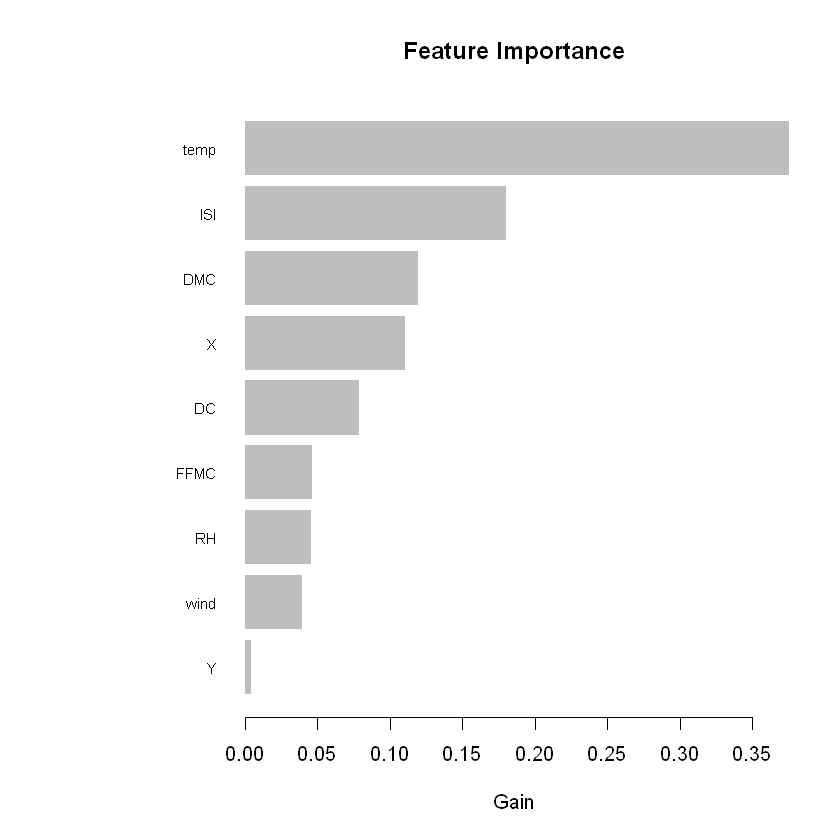

In [102]:
tree_imp <- lgb.importance(bst, percentage = TRUE)
lgb.plot.importance(tree_imp, top_n = 9L, measure = "Gain")

Here, the gain is the average training loss reduction gained when a particular feature is used for splitting. The importance of each feature is decided based on its overall gain value.[Read more](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27) 

From the above plot, we can see that temp has the highest normalized gain for splitting so it has been given highest importance followed by ISI, DMC, X, and DC.

## 6. Conclusion <a class="anchor" id="sec_6"></a>

So, we have performed statistical analysis on bushfire area prediction is performed. Here, we looked at several statistical measures that needs to be considered while modelling specifically on this time of small dataset. Several linear and non-linear models were developed with model assessment and selection we decided the best model to use for prediction based on comparision of their performance. To get a better understanding of whether these variables affect prediction of fire, some insights on variable selection was developed.

For further developement, several other predictors are necessaryto develop a more robust predictive model, and better answer the question of whether models for fire prediction change by season or not. Moreover, less number of data points and not enough information about the dataset makes it hard to conform the reasons for high spread of fire in certain regions. Year when each fire was caught is absent in the datast, which makes it more difficult to capture the non-linearity present.

## 7. References <a class="anchor" id="sec_7"></a>

* Friedman, J., Hastie, T., Simon, N., Tibshirani, R. (2016). R Package: glmnet.<br>Documentation: https://cran.r-project.org/web/packages/glmnet/glmnet.pdf
* Peters, A., Hothorn, T., Ripley, B., Therneau, T. (2019). R package: ipred.<br>Documentation: https://cran.r-project.org/web/packages/ipred/ipred.pdf
* Atkinson, B., Ripley, B., Therneau, T. (2019). R package: rpart.<br>Documentation: https://cran.r-project.org/web/packages/rpart/rpart.pdf
* Kuhn, M., Wing, J., Weston, S., Williams, A., Keefer, C. (2019). R package: caret.<br>Documentation: https://cran.r-project.org/web/packages/caret/caret.pdf
* Guolin, K., Meng, Q., Finley, T., Wang, T., Chen, W., Ma, W., Ye, Q. "LightGBM: A Highly Efficient Gradient Boosting Decision Tree". Advances in Neural Information Processing Systems 30 (NIPS 2017), pp. 3149-3157.
* Lundberg, S. (2018). *Interpretable Machine Learning with XGBoost*. <br>Retrieved from: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
* Malagaweather. *Fire Weather*. Retrived from: https://www.malagaweather.com/fwi-txt.htm
* Auburn University. *Weather Elements that Affect Fire Behavior*. Retrived from: https://www.auburn.edu/academic/forestry_wildlife/fire/weather_elements.htm
* Wikipedia. *Flammagenitus(Cloud)*. Retrived from: https://en.wikipedia.org/wiki/Flammagenitus_(cloud)
* EUMetrain. *Forest fires*. Retrived from: http://www.eumetrain.org/data/3/30/navmenu.php?tab=3&page=6.0.0

# Extra Work


### Ridge Regularization

In [103]:
train.mat <- model.matrix(log(area+1)~., data = fire_df[1:415,])[,-1]
test.mat <- model.matrix(log(area+1)~ ., data = fire_df[416:515,])[,-1]

In [104]:
grid <- 10^seq(4, -2, length = 100)

In [105]:
set.seed(1)# the purpose of fixing the seed of the random number generator is to make the result repeatable.
fit.ridge <- glmnet(train.mat, log(fire_df$area+1)[1:415], alpha = 0, lambda = grid, thresh = 1e-12)
cv.ridge <- cv.glmnet(train.mat, log(fire_df$area+1)[1:415], alpha = 0, lambda = grid, thresh = 1e-12)
bestlam.ridge <- cv.ridge$lambda.min
bestlam.ridge

[1] 1.321941

In [106]:
pred.ridge <- predict(fit.ridge, s = bestlam.ridge, newx = test.mat)
mean((pred.ridge - log(fire_df$area+1)[416:515])^2)

[1] 2.491663

L1 regularization:

In [107]:
set.seed(1)# the purpose of fixing the seed of the random number generator is to make the result repeatable.
fit.ridge <- glmnet(train.mat, log(fire_df$area+1)[1:415], alpha = 1, lambda = grid, thresh = 1e-12)
cv.ridge <- cv.glmnet(train.mat, log(fire_df$area+1)[1:415], alpha = 1, lambda = grid, thresh = 1e-12)
bestlam.ridge <- cv.ridge$lambda.min
bestlam.ridge

[1] 0.09326033

In [108]:
pred.ridge <- predict(fit.ridge, s = bestlam.ridge, newx = test.mat)
mean((pred.ridge - log(fire_df$area+1)[416:515])^2)

[1] 2.115406